In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
import simulators.cosmic_shear.cosmic_shear as cosmic_shear
import pickle
import compression.score.score as score
from scipy.linalg import block_diag
%matplotlib inline

In [2]:
### SET UP THE PRIOR ###

# number of nuisance parameters: must match number of photo-z bins
nz = 10

# Prior over theta
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
prior_covariance = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2
prior = priors.TruncatedGaussian(prior_mean, prior_covariance, lower, upper)

# Prior over eta (nuisances)
eta_lower = np.ones(nz)*-0.1
eta_upper = np.ones(nz)*0.1
eta_mean = np.zeros(nz)
eta_covariance = np.eye(nz)*0.05**2
eta_prior = priors.TruncatedGaussian(eta_mean, eta_covariance, eta_lower, eta_upper)

# Joint prior over nuisances and interesting parameters
joint_lower = np.concatenate([lower, eta_lower])
joint_upper = np.concatenate([upper, eta_upper])
joint_mean = np.concatenate([prior_mean, eta_mean])
joint_covariance = block_diag(prior_covariance, eta_covariance)
joint_prior = priors.TruncatedGaussian(joint_mean, 
                                       joint_covariance,
                                       joint_lower,
                                       joint_upper)

In [3]:
### SET UP THE SIMULATOR ###

# import tomographic n(z)
pz = pickle.load(open('simulators/cosmic_shear/pz_euclid.pkl', 'rb'))

# Set up the tomography simulations
CosmicShearSimulator = cosmic_shear.TomographicCosmicShearPhotoz(pz = pz, lmin = 10, lmax = 3000, n_ell_bins = 10, sigma_e = 0.3, nbar = 30, Area = 15000)

# Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args):
    
    # Draw nuisances from prior
    eta_prior = simulator_args[0]
    eta = eta_prior.draw()
    
    return CosmicShearSimulator.simulate(np.concatenate([theta, eta]), seed)
simulator_args = [eta_prior]

In [4]:
### SET UP THE COMPRESSOR ###

# Fiducial parameters
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
eta_fiducial = np.zeros(len(pz))

# Expected support of Wishart likelihood (fiducial inverse power spectrum)
C = CosmicShearSimulator.power_spectrum(np.concatenate([theta_fiducial, eta_fiducial]))
Cinv = np.array([np.linalg.inv(C[l,:,:]) for l in range(CosmicShearSimulator.n_ell_bins)])

# Degrees of freedom (effective number of modes per band power)
nl = CosmicShearSimulator.nl

# Calculate derivatives of the expected power spectrum
h = np.array(abs(theta_fiducial)*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = CosmicShearSimulator.compute_derivatives(np.concatenate([theta_fiducial, eta_fiducial]), h)

# Define compression as score-MLE of a Wishart likelihood
Compressor = score.Wishart(np.concatenate([theta_fiducial, eta_fiducial]), nl, Cinv, dCdt, prior_mean=joint_mean, prior_covariance=joint_covariance)

# Pull out Fisher matrix inverse
Finv = Compressor.Finv[0:5,0:5]

# Compressor function: This must have the form compressor(data, args) -> compressed summaries (pseudoMLE)
def compressor(d, compressor_args):
    return Compressor.projected_scoreMLE(d, np.arange(5,15))
compressor_args = None

In [5]:
### LOAD IN THE DATA VECTOR ###
data = compressor(simulator(theta_fiducial, 0, simulator_args), compressor_args)

In [6]:
# Create the neural density estimator (MAF)
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], 
                                               n_mades=5, act_fun=tf.tanh)

# Create the DELFI object
Delfi = delfi.Delfi(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', '\sigma_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results_marginal/maf")

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 33.4579, Val_loss: 35.1605
Epoch 00001, Train_loss: 19.7562, Val_loss: 19.9636
Epoch 00002, Train_loss: 17.5592, Val_loss: 17.7356
Epoch 00003, Train_loss: 16.8343, Val_loss: 16.9306
Epoch 00004, Train_loss: 16.6107, Val_loss: 16.4735
Epoch 00005, Train_loss: 15.9747, Val_loss: 15.9679
Epoch 00006, Train_loss: 15.5916, Val_loss: 15.5565
Epoch 00007, Train_loss: 15.2993, Val_loss: 15.2550
Epoch 00008, Train_loss: 14.7614, Val_loss: 14.7752
Epoch 00009, Train_loss: 14.2669, Val_loss: 14.3756
Epoch 00010, Train_loss: 13.5748, Val_loss: 13.6113
Epoch 00011, Train_loss: 13.2809, Val_loss: 13.3528
Epoch 00012, Train_loss: 12.9727, Val_loss: 13.0505
Epoch 00013, Train_loss: 12.0010, Val_loss: 12.0822
Epoch 00014, Train_loss: 11.1615, Val_loss: 11.2060
Epoch 00015, Train_loss: 10.7119, Val_loss: 10.8203
Epoch 00016, Train_loss: 10.3266, Val_loss: 10.3867
Epoch 00017, Train_loss: 10.2614, Va

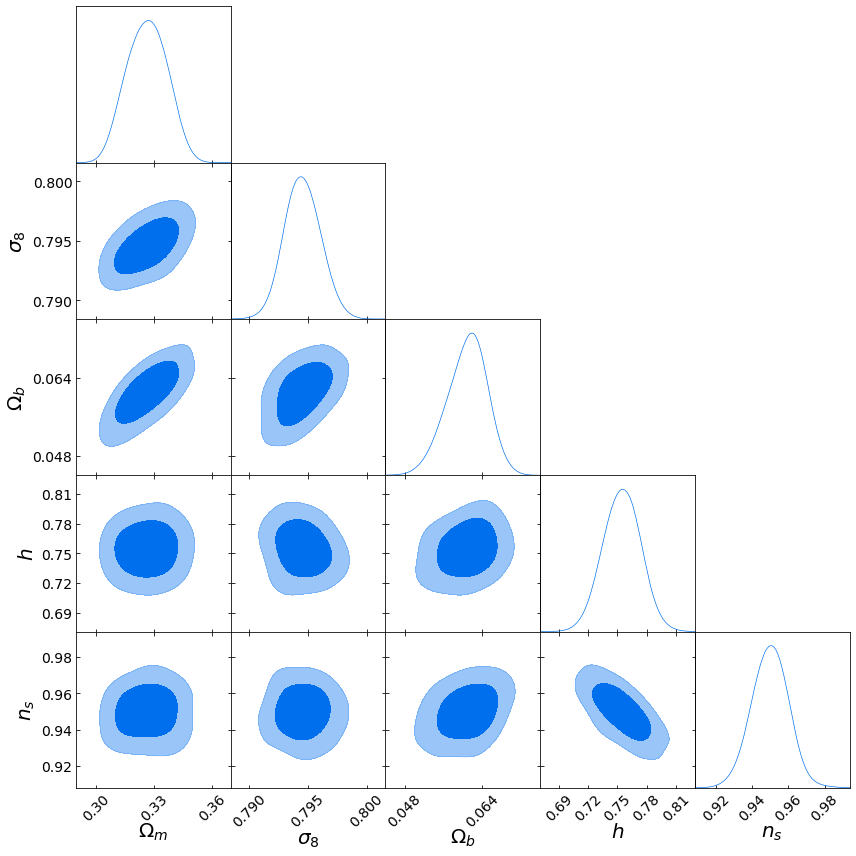

In [7]:
# Do the Fisher pre-training
Delfi.fisher_pretraining(50000, prior, epochs=100, patience=20)

Running initial 500 sims...
Done.
Epoch 00000, Train_loss: 14.8859, Val_loss: 15.4476
Epoch 00001, Train_loss: 12.3256, Val_loss: 12.5931
Epoch 00002, Train_loss: 12.3225, Val_loss: 12.3712
Epoch 00003, Train_loss: 11.8648, Val_loss: 11.9363
Epoch 00004, Train_loss: 11.3058, Val_loss: 11.3858
Epoch 00005, Train_loss: 10.9045, Val_loss: 11.0458
Epoch 00006, Train_loss: 10.6887, Val_loss: 10.9059
Epoch 00007, Train_loss: 10.4805, Val_loss: 10.6949
Epoch 00008, Train_loss: 10.3741, Val_loss: 10.6440
Epoch 00009, Train_loss: 10.2202, Val_loss: 10.5355
Epoch 00010, Train_loss: 10.1047, Val_loss: 10.3879
Epoch 00011, Train_loss: 10.0059, Val_loss: 10.3476
Epoch 00012, Train_loss: 9.9745, Val_loss: 10.3374
Epoch 00013, Train_loss: 9.8832, Val_loss: 10.3307
Epoch 00014, Train_loss: 9.9171, Val_loss: 10.4615
Epoch 00015, Train_loss: 9.8040, Val_loss: 10.3312
Epoch 00016, Train_loss: 9.7912, Val_loss: 10.4168
Epoch 00017, Train_loss: 9.6907, Val_loss: 10.2465
Epoch 00018, Train_loss: 9.6637, Val

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_0.pdf


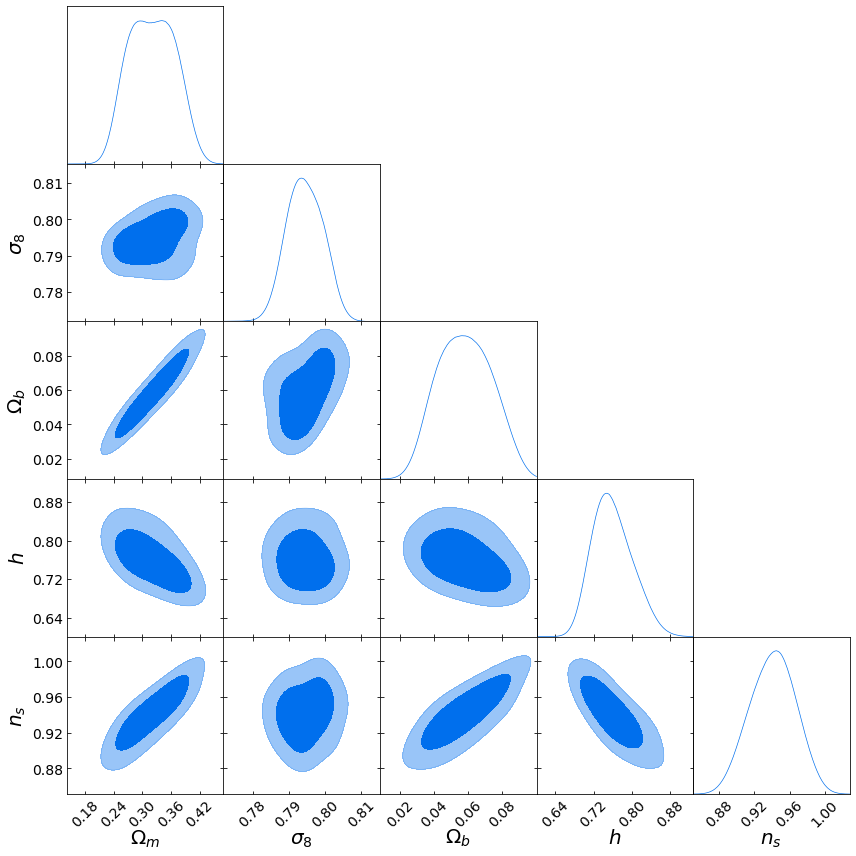

Population 1/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 10.3671, Val_loss: 10.7147
Epoch 00001, Train_loss: 10.2896, Val_loss: 10.7378
Epoch 00002, Train_loss: 10.2164, Val_loss: 10.6736
Epoch 00003, Train_loss: 10.0278, Val_loss: 10.4714
Epoch 00004, Train_loss: 9.9443, Val_loss: 10.3767
Epoch 00005, Train_loss: 9.9135, Val_loss: 10.4008
Epoch 00006, Train_loss: 9.8880, Val_loss: 10.3977
Epoch 00007, Train_loss: 9.8462, Val_loss: 10.3583
Epoch 00008, Train_loss: 9.8028, Val_loss: 10.3394
Epoch 00009, Train_loss: 9.7903, Val_loss: 10.3047
Epoch 00010, Train_loss: 9.8081, Val_loss: 10.3616
Epoch 00011, Train_loss: 9.8052, Val_loss: 10.3001
Epoch 00012, Train_loss: 9.7230, Val_loss: 10.3250
Epoch 00013, Train_loss: 9.7783, Val_loss: 10.4935
Epoch 00014, Train_loss: 9.7599, Val_loss: 10.4794
Epoch 00015, Train_loss: 9.6842, Val_loss: 10.3195
Epoch 00016, Train_loss: 9.7511, Val_loss: 10.3032
Epoch 00017, Train_loss: 9.7060, Val_loss: 10.3093
E

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_1.pdf


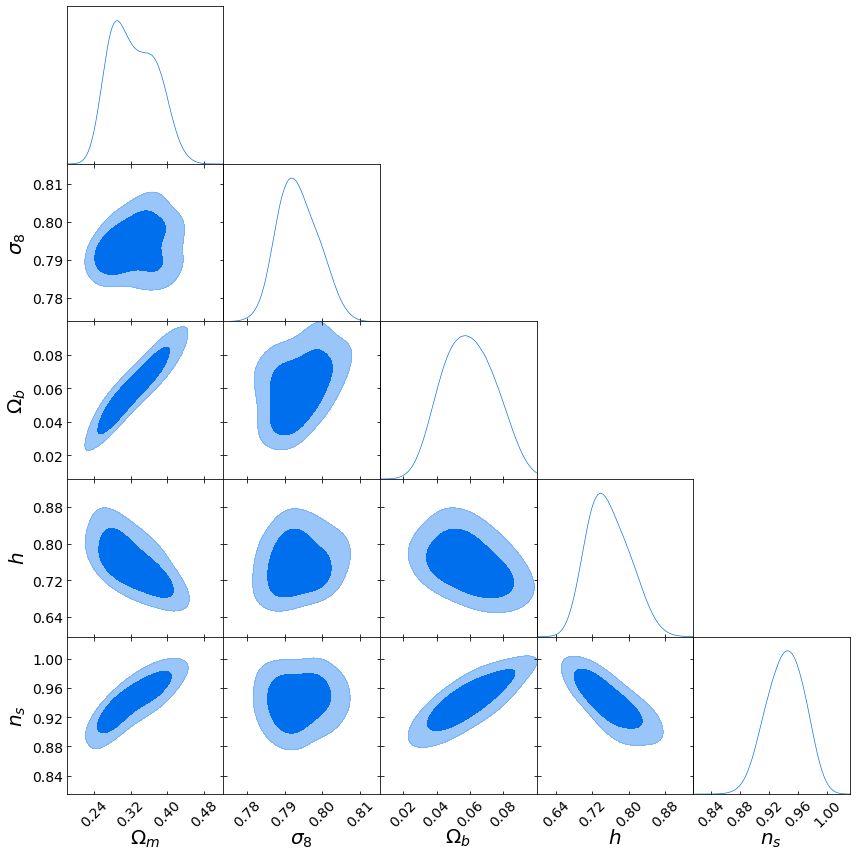

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


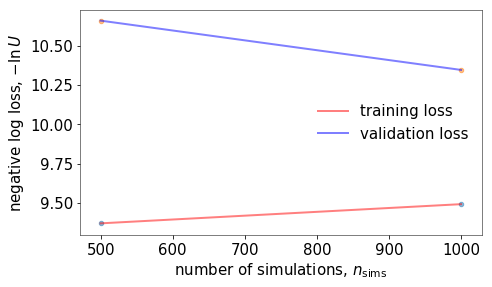

Population 2/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.9787, Val_loss: 10.2771
Epoch 00001, Train_loss: 9.9387, Val_loss: 10.3181
Epoch 00002, Train_loss: 9.8979, Val_loss: 10.2882
Epoch 00003, Train_loss: 9.9146, Val_loss: 10.3188
Epoch 00004, Train_loss: 9.8428, Val_loss: 10.2818
Epoch 00005, Train_loss: 9.8131, Val_loss: 10.2495
Epoch 00006, Train_loss: 9.7917, Val_loss: 10.2312
Epoch 00007, Train_loss: 9.7905, Val_loss: 10.3014
Epoch 00008, Train_loss: 9.7765, Val_loss: 10.2827
Epoch 00009, Train_loss: 9.7677, Val_loss: 10.2950
Epoch 00010, Train_loss: 9.7544, Val_loss: 10.2764
Epoch 00011, Train_loss: 9.7359, Val_loss: 10.2680
Epoch 00012, Train_loss: 9.7126, Val_loss: 10.2928
Epoch 00013, Train_loss: 9.7217, Val_loss: 10.3052
Epoch 00014, Train_loss: 9.7072, Val_loss: 10.2741
Epoch 00015, Train_loss: 9.6748, Val_loss: 10.2867
Epoch 00016, Train_loss: 9.6785, Val_loss: 10.3002
Epoch 00017, Train_loss: 9.6835, Val_loss: 10.2989
Epoch

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_2.pdf


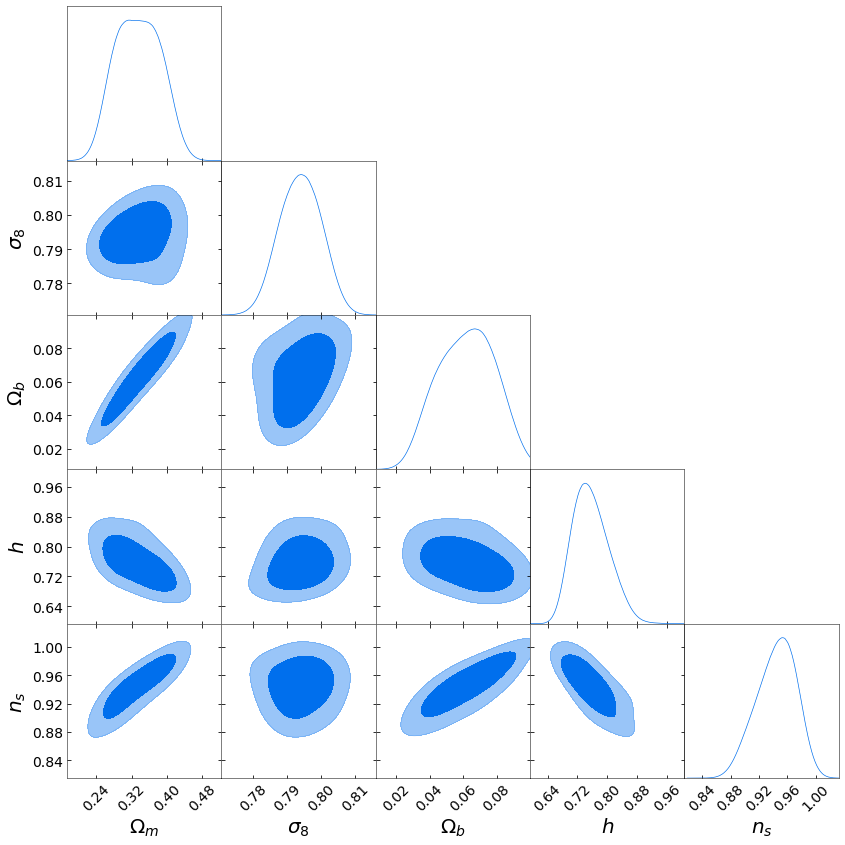

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


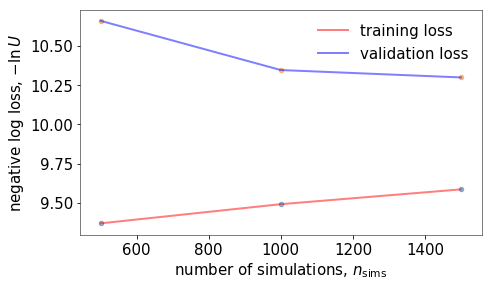

Population 3/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.9388, Val_loss: 9.9530
Epoch 00001, Train_loss: 9.9152, Val_loss: 9.9026
Epoch 00002, Train_loss: 9.8679, Val_loss: 9.9028
Epoch 00003, Train_loss: 9.8417, Val_loss: 9.9172
Epoch 00004, Train_loss: 9.8260, Val_loss: 9.9138
Epoch 00005, Train_loss: 9.8142, Val_loss: 9.8920
Epoch 00006, Train_loss: 9.7942, Val_loss: 9.9230
Epoch 00007, Train_loss: 9.8013, Val_loss: 9.8876
Epoch 00008, Train_loss: 9.7818, Val_loss: 9.9211
Epoch 00009, Train_loss: 9.7719, Val_loss: 9.9144
Epoch 00010, Train_loss: 9.7488, Val_loss: 9.8805
Epoch 00011, Train_loss: 9.7443, Val_loss: 9.9092
Epoch 00012, Train_loss: 9.7603, Val_loss: 9.9252
Epoch 00013, Train_loss: 9.7606, Val_loss: 9.9433
Epoch 00014, Train_loss: 9.7178, Val_loss: 9.8997
Epoch 00015, Train_loss: 9.7139, Val_loss: 9.9033
Epoch 00016, Train_loss: 9.7100, Val_loss: 9.9444
Epoch 00017, Train_loss: 9.7198, Val_loss: 9.9501
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_3.pdf


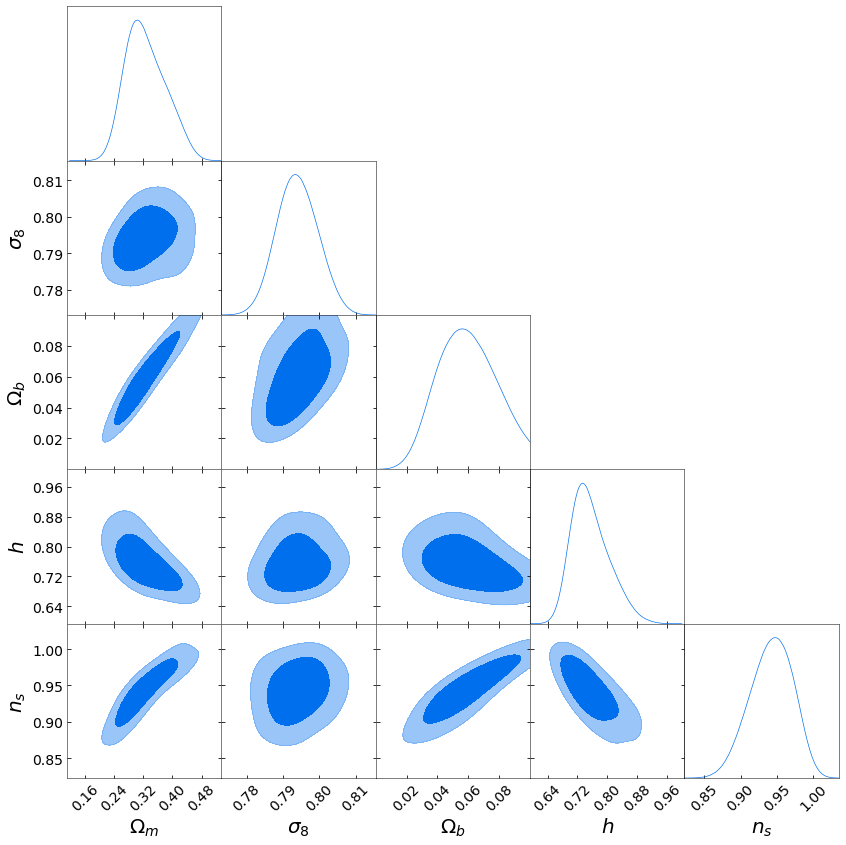

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


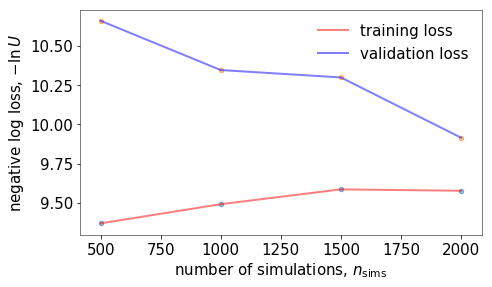

Population 4/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.7702, Val_loss: 9.9595
Epoch 00001, Train_loss: 9.8290, Val_loss: 10.0505
Epoch 00002, Train_loss: 9.7622, Val_loss: 9.9890
Epoch 00003, Train_loss: 9.7469, Val_loss: 9.9717
Epoch 00004, Train_loss: 9.7249, Val_loss: 9.9649
Epoch 00005, Train_loss: 9.7259, Val_loss: 9.9813
Epoch 00006, Train_loss: 9.7276, Val_loss: 9.9795
Epoch 00007, Train_loss: 9.7230, Val_loss: 9.9771
Epoch 00008, Train_loss: 9.7166, Val_loss: 9.9953
Epoch 00009, Train_loss: 9.7037, Val_loss: 9.9715
Epoch 00010, Train_loss: 9.7159, Val_loss: 10.0082
Epoch 00011, Train_loss: 9.6952, Val_loss: 9.9880
Epoch 00012, Train_loss: 9.6725, Val_loss: 9.9816
Epoch 00013, Train_loss: 9.6878, Val_loss: 9.9789
Epoch 00014, Train_loss: 9.6693, Val_loss: 9.9951
Epoch 00015, Train_loss: 9.6746, Val_loss: 9.9979
Epoch 00016, Train_loss: 9.6685, Val_loss: 9.9683
Epoch 00017, Train_loss: 9.6511, Val_loss: 9.9931
Epoch 00018, Train_lo

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_4.pdf


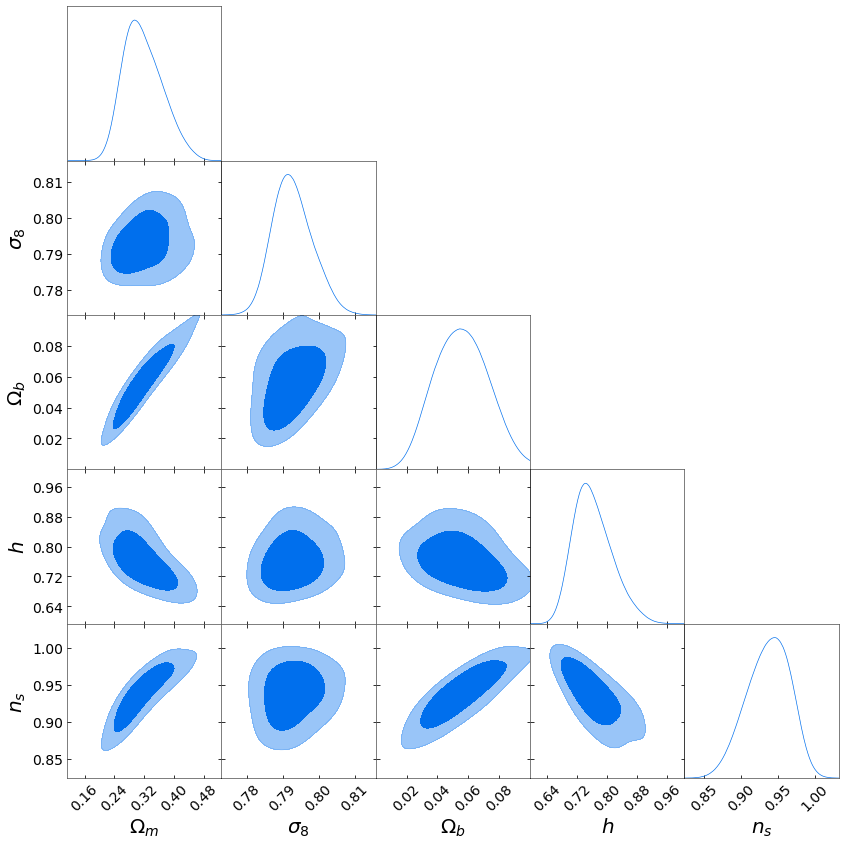

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


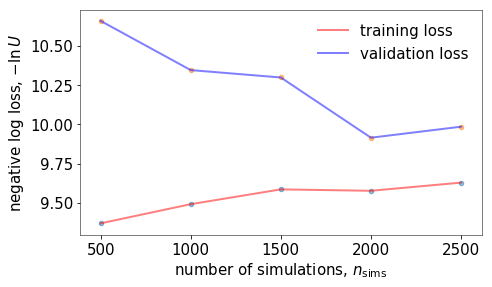

Population 5/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8618, Val_loss: 9.7811
Epoch 00001, Train_loss: 9.8364, Val_loss: 9.7402
Epoch 00002, Train_loss: 9.8208, Val_loss: 9.7728
Epoch 00003, Train_loss: 9.8026, Val_loss: 9.7386
Epoch 00004, Train_loss: 9.7909, Val_loss: 9.7545
Epoch 00005, Train_loss: 9.7774, Val_loss: 9.7473
Epoch 00006, Train_loss: 9.7719, Val_loss: 9.7427
Epoch 00007, Train_loss: 9.7650, Val_loss: 9.7451
Epoch 00008, Train_loss: 9.7629, Val_loss: 9.7512
Epoch 00009, Train_loss: 9.7461, Val_loss: 9.7403
Epoch 00010, Train_loss: 9.7564, Val_loss: 9.7706
Epoch 00011, Train_loss: 9.7496, Val_loss: 9.7617
Epoch 00012, Train_loss: 9.7308, Val_loss: 9.7504
Epoch 00013, Train_loss: 9.7317, Val_loss: 9.7402
Epoch 00014, Train_loss: 9.7487, Val_loss: 9.8009
Epoch 00015, Train_loss: 9.7225, Val_loss: 9.7440
Epoch 00016, Train_loss: 9.7213, Val_loss: 9.7646
Epoch 00017, Train_loss: 9.7184, Val_loss: 9.7783
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_5.pdf


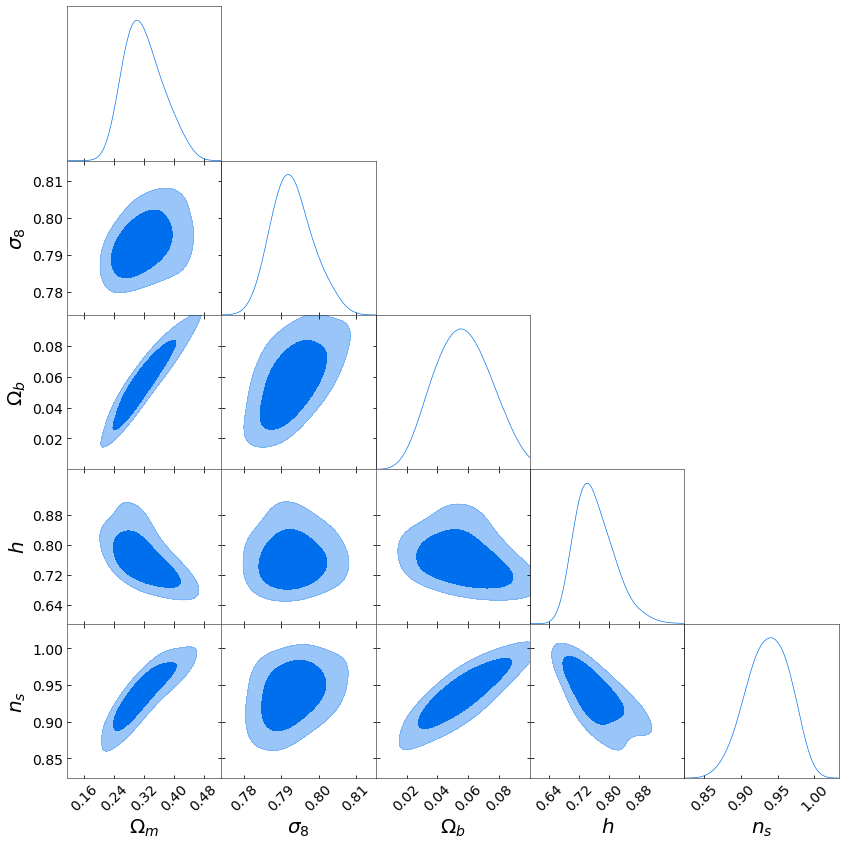

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


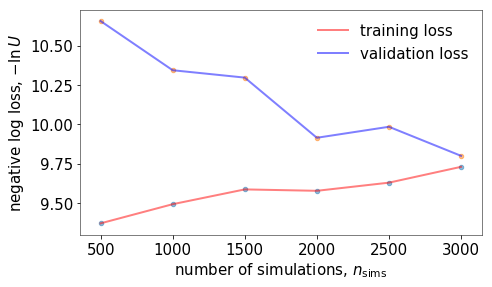

Population 6/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8394, Val_loss: 9.9813
Epoch 00001, Train_loss: 9.8204, Val_loss: 9.9591
Epoch 00002, Train_loss: 9.8087, Val_loss: 9.9629
Epoch 00003, Train_loss: 9.8141, Val_loss: 9.9768
Epoch 00004, Train_loss: 9.8022, Val_loss: 9.9668
Epoch 00005, Train_loss: 9.7869, Val_loss: 9.9815
Epoch 00006, Train_loss: 9.7865, Val_loss: 9.9751
Epoch 00007, Train_loss: 9.7823, Val_loss: 9.9929
Epoch 00008, Train_loss: 9.7678, Val_loss: 9.9679
Epoch 00009, Train_loss: 9.7507, Val_loss: 9.9769
Epoch 00010, Train_loss: 9.7568, Val_loss: 9.9996
Epoch 00011, Train_loss: 9.7724, Val_loss: 10.0435
Epoch 00012, Train_loss: 9.7391, Val_loss: 9.9786
Epoch 00013, Train_loss: 9.7383, Val_loss: 9.9957
Epoch 00014, Train_loss: 9.7316, Val_loss: 9.9747
Epoch 00015, Train_loss: 9.7336, Val_loss: 10.0129
Epoch 00016, Train_loss: 9.7316, Val_loss: 10.0016
Epoch 00017, Train_loss: 9.7132, Val_loss: 9.9885
Epoch 00018, Train_l

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_6.pdf


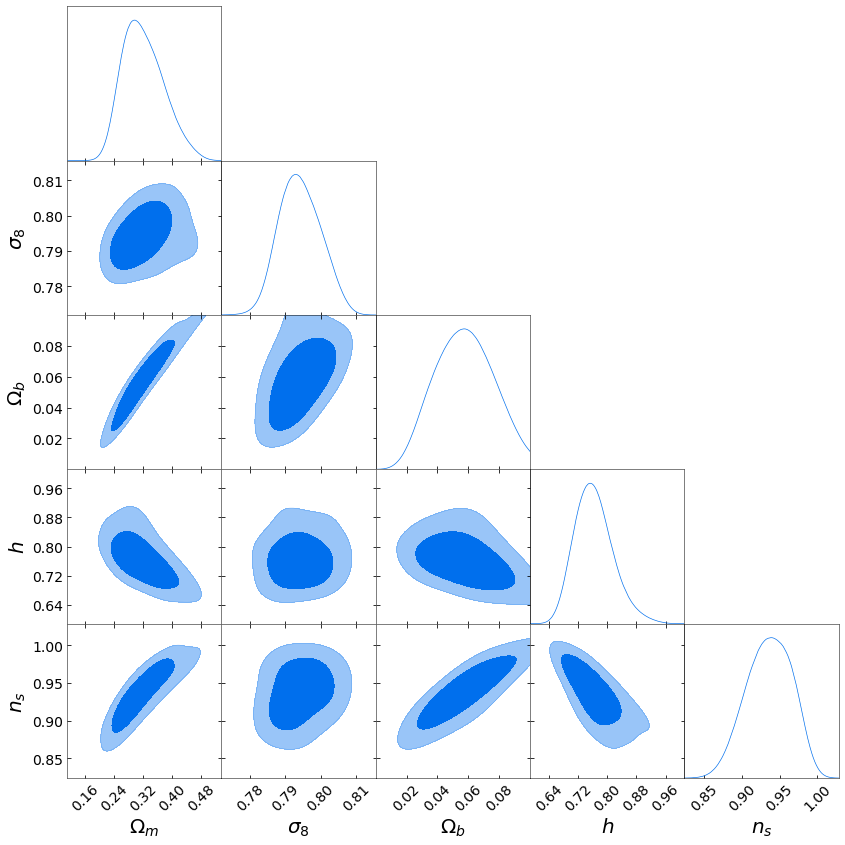

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


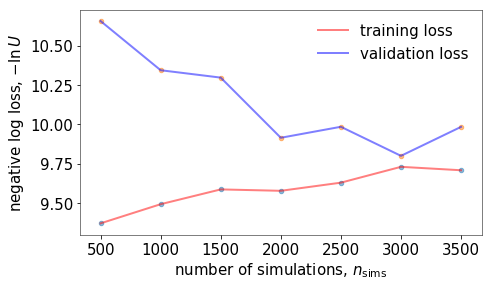

Population 7/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.9074, Val_loss: 9.7735
Epoch 00001, Train_loss: 9.8925, Val_loss: 9.7632
Epoch 00002, Train_loss: 9.8760, Val_loss: 9.7634
Epoch 00003, Train_loss: 9.8678, Val_loss: 9.7634
Epoch 00004, Train_loss: 9.8583, Val_loss: 9.7694
Epoch 00005, Train_loss: 9.8555, Val_loss: 9.7750
Epoch 00006, Train_loss: 9.8398, Val_loss: 9.7660
Epoch 00007, Train_loss: 9.8634, Val_loss: 9.7681
Epoch 00008, Train_loss: 9.8247, Val_loss: 9.7450
Epoch 00009, Train_loss: 9.8215, Val_loss: 9.7672
Epoch 00010, Train_loss: 9.8091, Val_loss: 9.7467
Epoch 00011, Train_loss: 9.8065, Val_loss: 9.7525
Epoch 00012, Train_loss: 9.7948, Val_loss: 9.7398
Epoch 00013, Train_loss: 9.7901, Val_loss: 9.7365
Epoch 00014, Train_loss: 9.8194, Val_loss: 9.7602
Epoch 00015, Train_loss: 9.7865, Val_loss: 9.7556
Epoch 00016, Train_loss: 9.7758, Val_loss: 9.7443
Epoch 00017, Train_loss: 9.8117, Val_loss: 9.7593
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_7.pdf


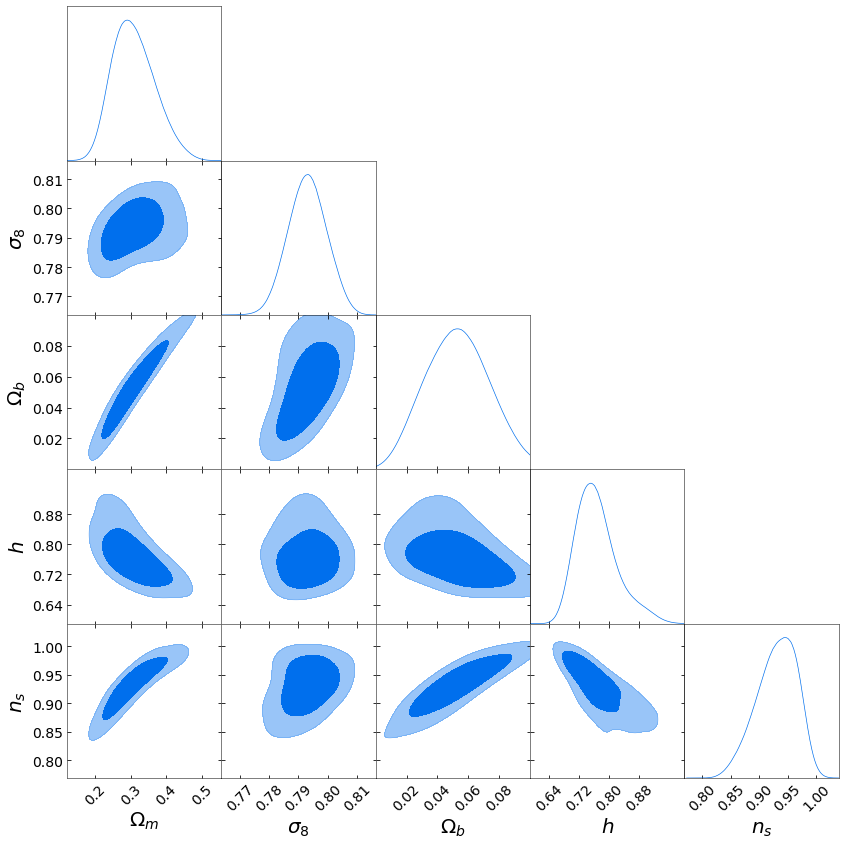

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


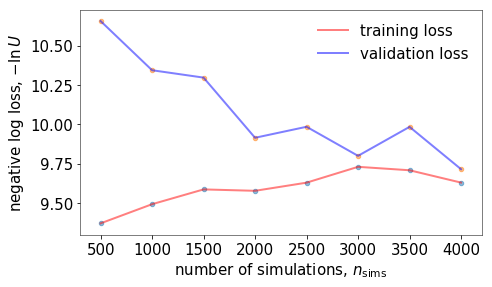

Population 8/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8071, Val_loss: 9.7733
Epoch 00001, Train_loss: 9.7988, Val_loss: 9.7723
Epoch 00002, Train_loss: 9.7821, Val_loss: 9.7787
Epoch 00003, Train_loss: 9.7845, Val_loss: 9.8056
Epoch 00004, Train_loss: 9.7669, Val_loss: 9.7928
Epoch 00005, Train_loss: 9.7583, Val_loss: 9.8017
Epoch 00006, Train_loss: 9.7607, Val_loss: 9.8017
Epoch 00007, Train_loss: 9.7677, Val_loss: 9.8005
Epoch 00008, Train_loss: 9.7509, Val_loss: 9.8081
Epoch 00009, Train_loss: 9.7589, Val_loss: 9.8240
Epoch 00010, Train_loss: 9.7420, Val_loss: 9.8213
Epoch 00011, Train_loss: 9.7376, Val_loss: 9.8078
Epoch 00012, Train_loss: 9.7505, Val_loss: 9.8351
Epoch 00013, Train_loss: 9.7387, Val_loss: 9.8468
Epoch 00014, Train_loss: 9.7284, Val_loss: 9.8270
Epoch 00015, Train_loss: 9.7214, Val_loss: 9.8193
Epoch 00016, Train_loss: 9.7155, Val_loss: 9.8336
Epoch 00017, Train_loss: 9.7061, Val_loss: 9.8235
Epoch 00018, Train_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_8.pdf


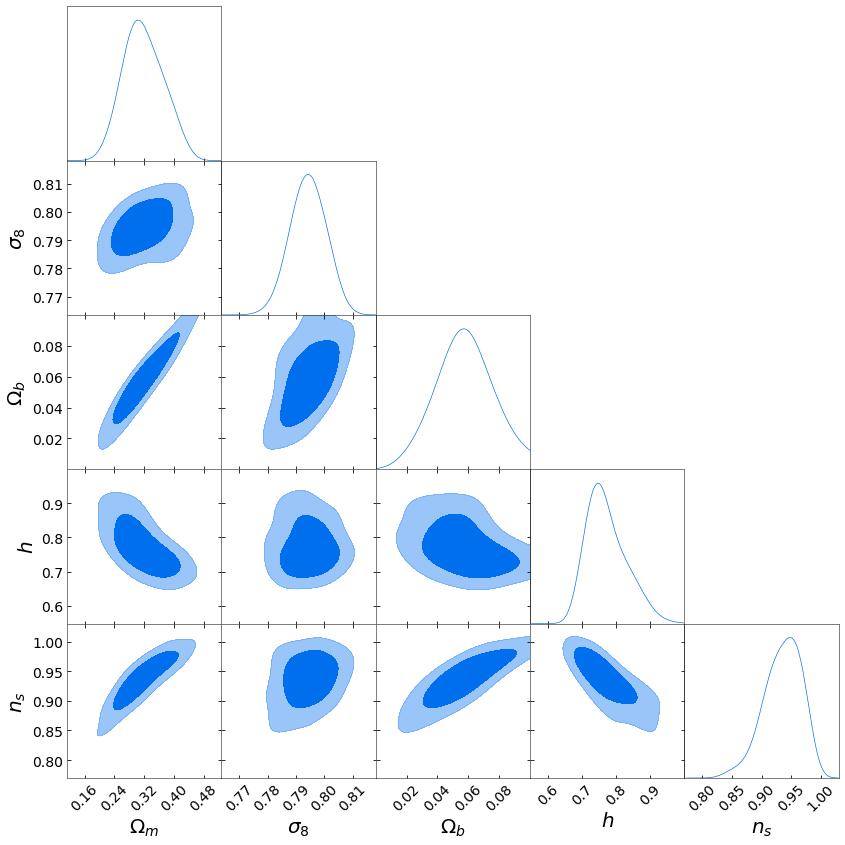

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


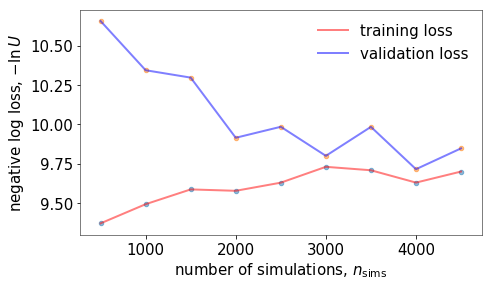

Population 9/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.16614795 0.79450868 0.01299387 0.83838801 0.85974671] (rank 0)
Done.
Epoch 00000, Train_loss: 9.7883, Val_loss: 9.9495
Epoch 00001, Train_loss: 9.7803, Val_loss: 9.9766
Epoch 00002, Train_loss: 9.7774, Val_loss: 9.9801
Epoch 00003, Train_loss: 9.7669, Val_loss: 9.9840
Epoch 00004, Train_loss: 9.7779, Val_loss: 9.9910
Epoch 00005, Train_loss: 9.7706, Val_loss: 9.9979
Epoch 00006, Train_loss: 9.7669, Val_loss: 10.0136
Epoch 00007, Train_loss: 9.7518, Val_loss: 10.0007
Epoch 00008, Train_loss: 9.7511, Val_loss: 9.9999
Epoch 00009, Train_loss: 9.7457, Val_loss: 9.9987
Epoch 00010, Train_loss: 9.7363, Val_loss: 9.9918
Epoch 00011, Train_loss: 9.7361, Val_loss: 10.0063
Epoch 00012, Train_loss: 9.7315, Val_loss: 9.9924
Epoch 00013, Train_loss: 9.7313, Val_loss: 10.0051
Epoch 00014, Train_loss: 9.7291, Val_loss: 9.9763
Epoch 00015, Train_loss: 9.7428, Val_loss: 10.0046
Ep

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_9.pdf


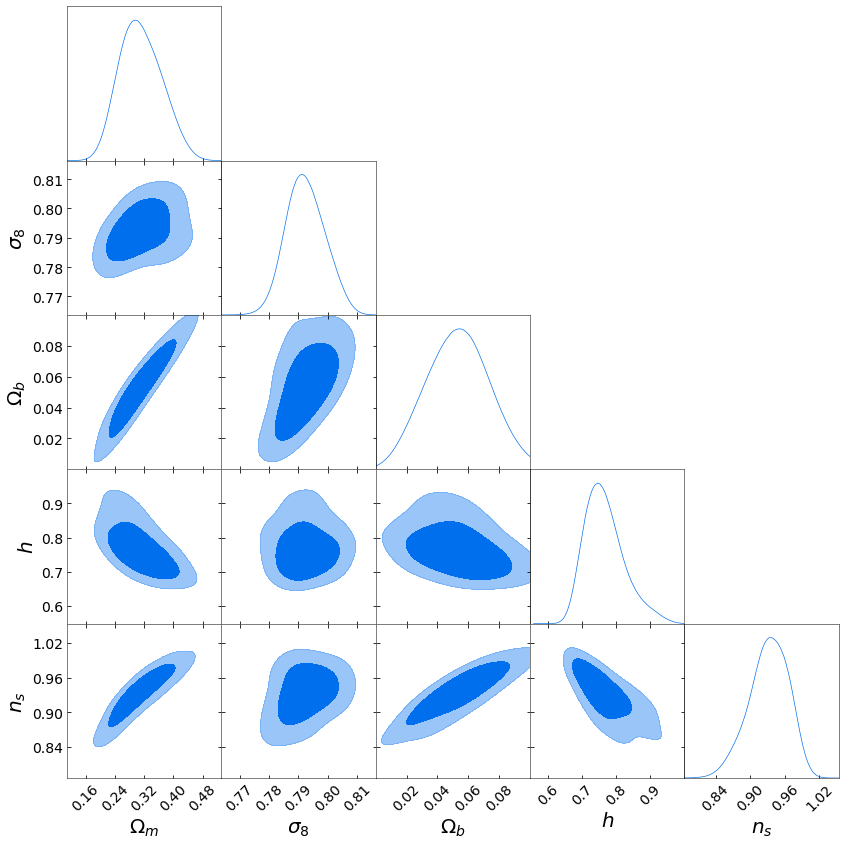

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


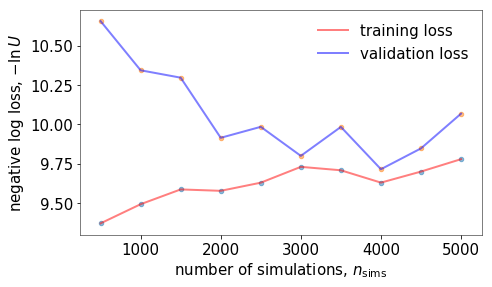

Population 10/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8512, Val_loss: 9.8347
Epoch 00001, Train_loss: 9.8413, Val_loss: 9.8469
Epoch 00002, Train_loss: 9.8243, Val_loss: 9.8490
Epoch 00003, Train_loss: 9.8214, Val_loss: 9.8438
Epoch 00004, Train_loss: 9.8139, Val_loss: 9.8518
Epoch 00005, Train_loss: 9.8097, Val_loss: 9.8421
Epoch 00006, Train_loss: 9.8110, Val_loss: 9.8499
Epoch 00007, Train_loss: 9.8019, Val_loss: 9.8528
Epoch 00008, Train_loss: 9.7997, Val_loss: 9.8518
Epoch 00009, Train_loss: 9.8068, Val_loss: 9.8566
Epoch 00010, Train_loss: 9.8012, Val_loss: 9.8608
Epoch 00011, Train_loss: 9.7876, Val_loss: 9.8488
Epoch 00012, Train_loss: 9.7881, Val_loss: 9.8771
Epoch 00013, Train_loss: 9.7781, Val_loss: 9.8595
Epoch 00014, Train_loss: 9.7785, Val_loss: 9.8561
Epoch 00015, Train_loss: 9.7967, Val_loss: 9.9016
Epoch 00016, Train_loss: 9.7725, Val_loss: 9.8666
Epoch 00017, Train_loss: 9.7664, Val_loss: 9.8620
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_10.pdf


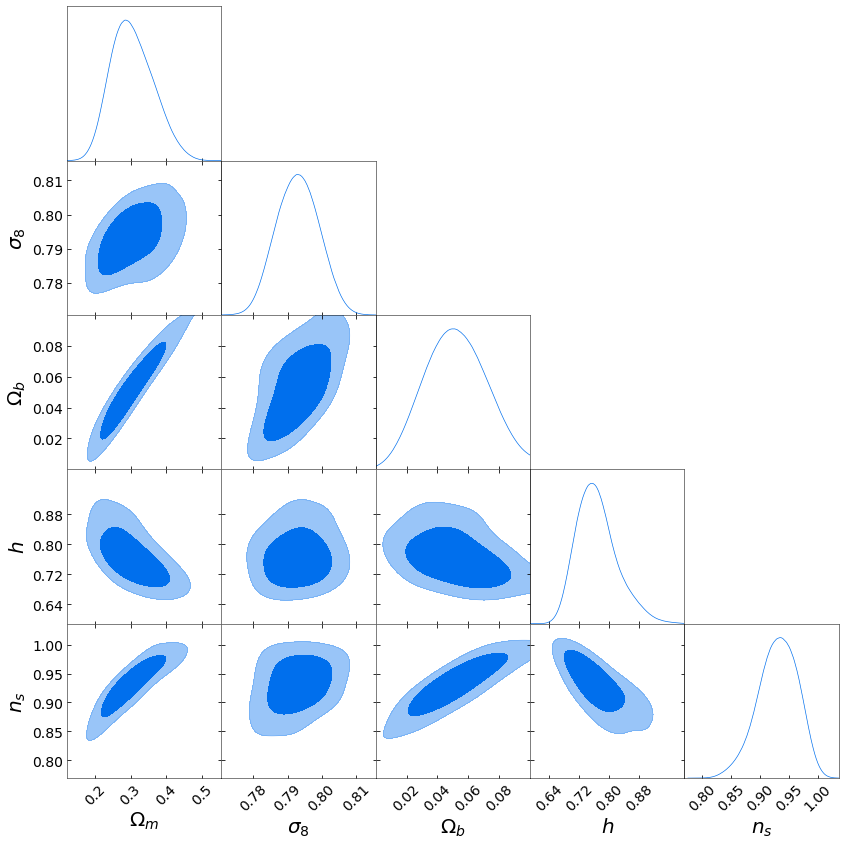

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


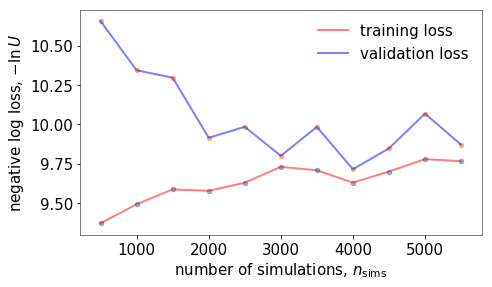

Population 11/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8722, Val_loss: 9.6909
Epoch 00001, Train_loss: 9.8658, Val_loss: 9.7033
Epoch 00002, Train_loss: 9.8678, Val_loss: 9.7038
Epoch 00003, Train_loss: 9.8556, Val_loss: 9.7153
Epoch 00004, Train_loss: 9.8502, Val_loss: 9.7046
Epoch 00005, Train_loss: 9.8469, Val_loss: 9.7136
Epoch 00006, Train_loss: 9.8459, Val_loss: 9.7130
Epoch 00007, Train_loss: 9.8472, Val_loss: 9.7263
Epoch 00008, Train_loss: 9.8535, Val_loss: 9.7423
Epoch 00009, Train_loss: 9.8659, Val_loss: 9.7599
Epoch 00010, Train_loss: 9.8321, Val_loss: 9.7209
Epoch 00011, Train_loss: 9.8249, Val_loss: 9.7174
Epoch 00012, Train_loss: 9.8178, Val_loss: 9.7203
Epoch 00013, Train_loss: 9.8423, Val_loss: 9.7494
Epoch 00014, Train_loss: 9.8113, Val_loss: 9.7219
Epoch 00015, Train_loss: 9.8130, Val_loss: 9.7288
Epoch 00016, Train_loss: 9.8043, Val_loss: 9.7164
Epoch 00017, Train_loss: 9.8092, Val_loss: 9.7325
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_11.pdf


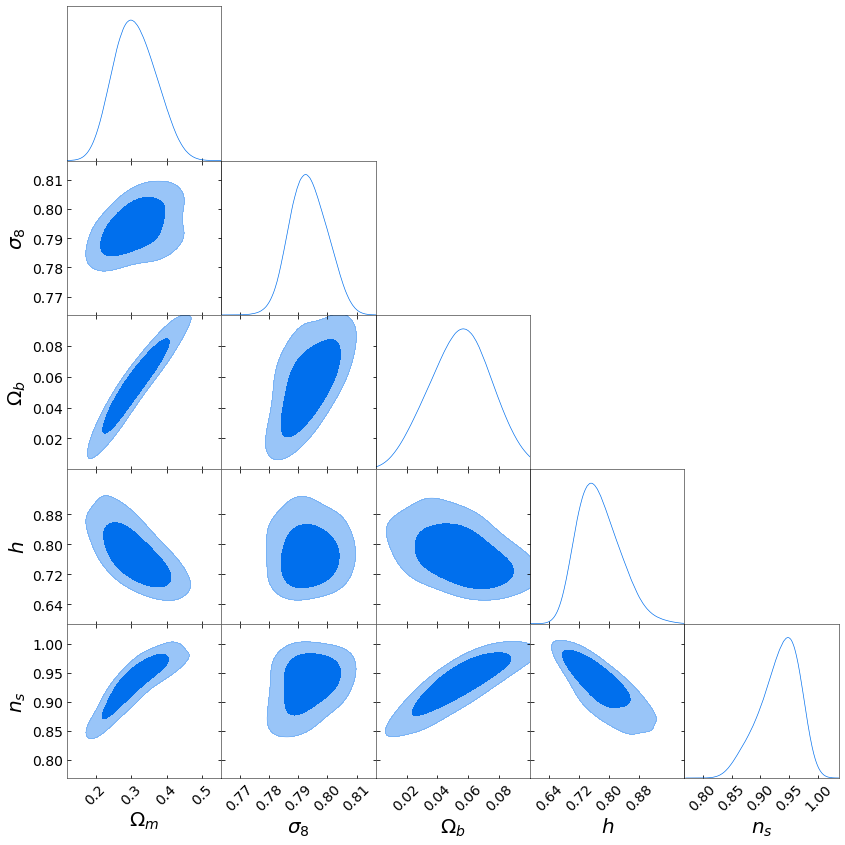

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


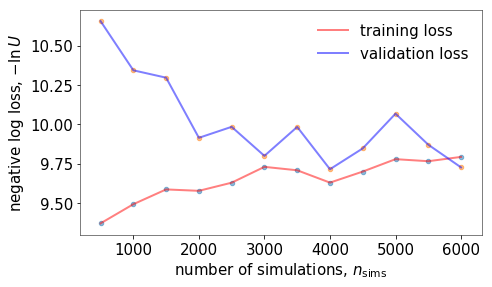

Population 12/23
Sampling proposal density...
Done.
Running 500 sims...


/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_JUSTIN/simulators/cosmic_shear/cosmic_shear.py:258: RuntimeWarning: invalid value encountered in log
  logpkz = np.log(cosmo.pk(np.exp(logk), z2a(z)))


Simulator returns exception for parameter values: [0.32324888 0.79352436 0.0579417  0.75434271 0.94587344] (rank 0)
Done.
Epoch 00000, Train_loss: 9.8810, Val_loss: 9.7707
Epoch 00001, Train_loss: 9.8682, Val_loss: 9.7681
Epoch 00002, Train_loss: 9.8658, Val_loss: 9.7729
Epoch 00003, Train_loss: 9.8584, Val_loss: 9.7694
Epoch 00004, Train_loss: 9.8640, Val_loss: 9.7797
Epoch 00005, Train_loss: 9.8656, Val_loss: 9.7908
Epoch 00006, Train_loss: 9.8543, Val_loss: 9.7800
Epoch 00007, Train_loss: 9.8632, Val_loss: 9.7927
Epoch 00008, Train_loss: 9.8454, Val_loss: 9.7800
Epoch 00009, Train_loss: 9.8444, Val_loss: 9.7826
Epoch 00010, Train_loss: 9.8333, Val_loss: 9.7720
Epoch 00011, Train_loss: 9.8284, Val_loss: 9.7742
Epoch 00012, Train_loss: 9.8401, Val_loss: 9.7861
Epoch 00013, Train_loss: 9.8296, Val_loss: 9.7756
Epoch 00014, Train_loss: 9.8474, Val_loss: 9.7954
Epoch 00015, Train_loss: 9.8584, Val_loss: 9.8249
Epoch 00016, Train_loss: 9.8277, Val_loss: 9.7799
Epoch 00017, Train_loss: 9.8

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_12.pdf


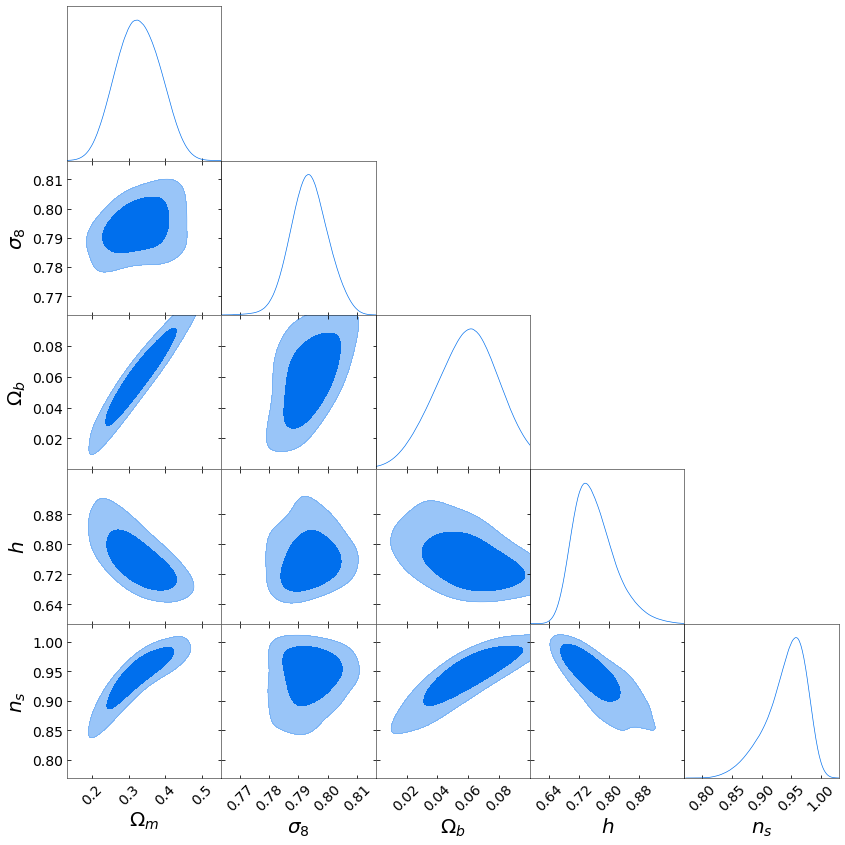

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


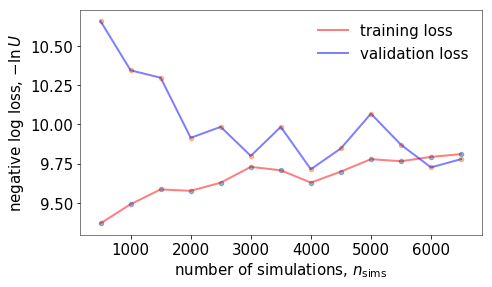

Population 13/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8770, Val_loss: 9.9649
Epoch 00001, Train_loss: 9.8690, Val_loss: 9.9736
Epoch 00002, Train_loss: 9.8567, Val_loss: 9.9615
Epoch 00003, Train_loss: 9.8540, Val_loss: 9.9794
Epoch 00004, Train_loss: 9.8559, Val_loss: 9.9727
Epoch 00005, Train_loss: 9.8729, Val_loss: 10.0038
Epoch 00006, Train_loss: 9.8535, Val_loss: 9.9822
Epoch 00007, Train_loss: 9.8335, Val_loss: 9.9752
Epoch 00008, Train_loss: 9.8336, Val_loss: 9.9807
Epoch 00009, Train_loss: 9.8215, Val_loss: 9.9701
Epoch 00010, Train_loss: 9.8249, Val_loss: 9.9758
Epoch 00011, Train_loss: 9.8171, Val_loss: 9.9725
Epoch 00012, Train_loss: 9.8184, Val_loss: 9.9794
Epoch 00013, Train_loss: 9.8139, Val_loss: 9.9769
Epoch 00014, Train_loss: 9.8108, Val_loss: 9.9766
Epoch 00015, Train_loss: 9.8104, Val_loss: 9.9783
Epoch 00016, Train_loss: 9.8028, Val_loss: 9.9729
Epoch 00017, Train_loss: 9.8018, Val_loss: 9.9864
Epoch 00018, Train_lo

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_13.pdf


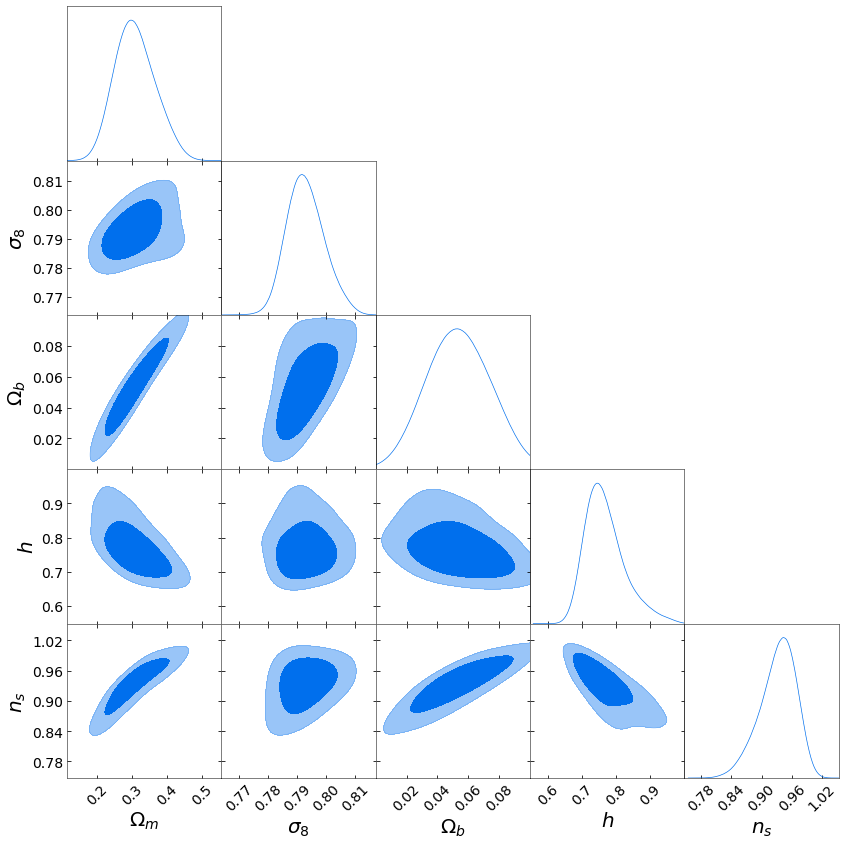

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


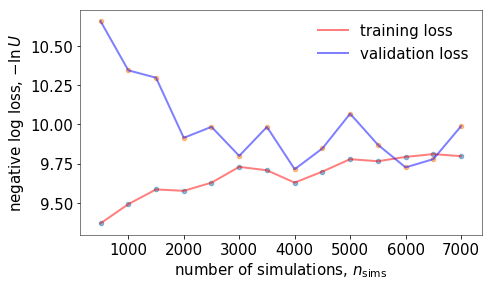

Population 14/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8846, Val_loss: 9.8908
Epoch 00001, Train_loss: 9.8685, Val_loss: 9.8777
Epoch 00002, Train_loss: 9.8679, Val_loss: 9.8808
Epoch 00003, Train_loss: 9.8667, Val_loss: 9.8894
Epoch 00004, Train_loss: 9.8713, Val_loss: 9.8948
Epoch 00005, Train_loss: 9.8643, Val_loss: 9.8998
Epoch 00006, Train_loss: 9.8544, Val_loss: 9.8868
Epoch 00007, Train_loss: 9.8471, Val_loss: 9.8847
Epoch 00008, Train_loss: 9.8486, Val_loss: 9.8863
Epoch 00009, Train_loss: 9.8358, Val_loss: 9.8780
Epoch 00010, Train_loss: 9.8319, Val_loss: 9.8805
Epoch 00011, Train_loss: 9.8305, Val_loss: 9.8786
Epoch 00012, Train_loss: 9.8259, Val_loss: 9.8778
Epoch 00013, Train_loss: 9.8314, Val_loss: 9.8814
Epoch 00014, Train_loss: 9.8249, Val_loss: 9.8822
Epoch 00015, Train_loss: 9.8286, Val_loss: 9.8886
Epoch 00016, Train_loss: 9.8266, Val_loss: 9.8888
Epoch 00017, Train_loss: 9.8179, Val_loss: 9.8838
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_14.pdf


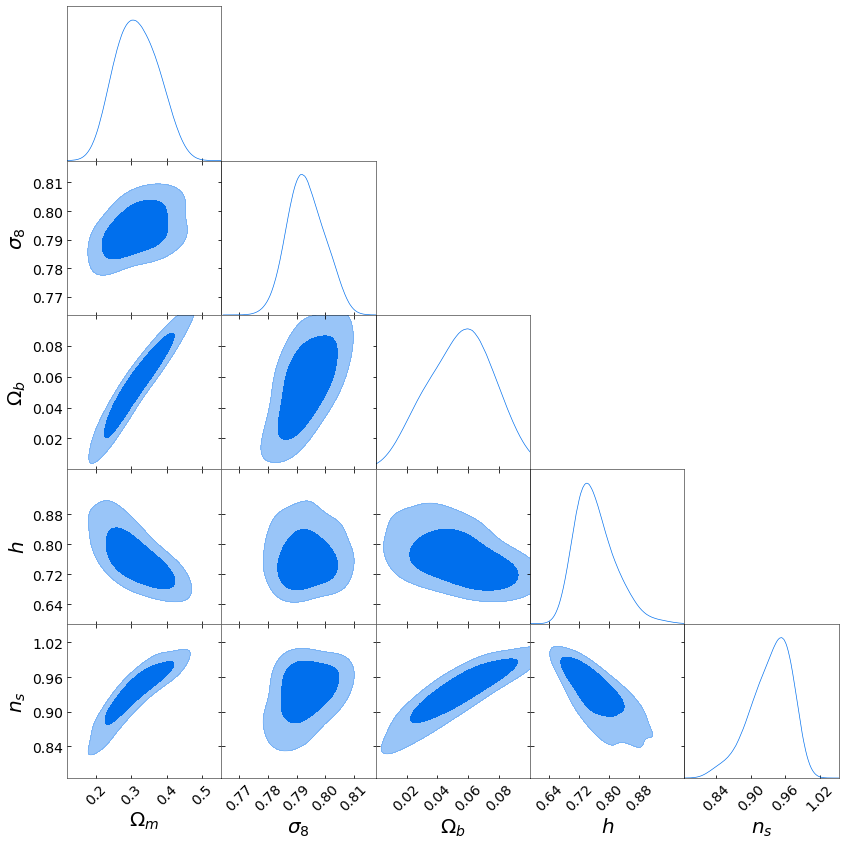

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


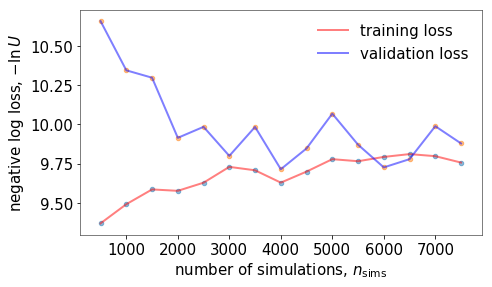

Population 15/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8090, Val_loss: 9.7635
Epoch 00001, Train_loss: 9.8028, Val_loss: 9.7556
Epoch 00002, Train_loss: 9.8034, Val_loss: 9.7738
Epoch 00003, Train_loss: 9.7987, Val_loss: 9.7607
Epoch 00004, Train_loss: 9.7977, Val_loss: 9.7851
Epoch 00005, Train_loss: 9.7898, Val_loss: 9.7794
Epoch 00006, Train_loss: 9.7935, Val_loss: 9.7772
Epoch 00007, Train_loss: 9.7917, Val_loss: 9.7878
Epoch 00008, Train_loss: 9.8019, Val_loss: 9.8171
Epoch 00009, Train_loss: 9.7814, Val_loss: 9.7776
Epoch 00010, Train_loss: 9.7803, Val_loss: 9.7844
Epoch 00011, Train_loss: 9.7749, Val_loss: 9.7914
Epoch 00012, Train_loss: 9.7740, Val_loss: 9.7864
Epoch 00013, Train_loss: 9.7830, Val_loss: 9.8095
Epoch 00014, Train_loss: 9.7795, Val_loss: 9.7969
Epoch 00015, Train_loss: 9.7791, Val_loss: 9.7968
Epoch 00016, Train_loss: 9.7925, Val_loss: 9.8061
Epoch 00017, Train_loss: 9.7671, Val_loss: 9.8006
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_15.pdf


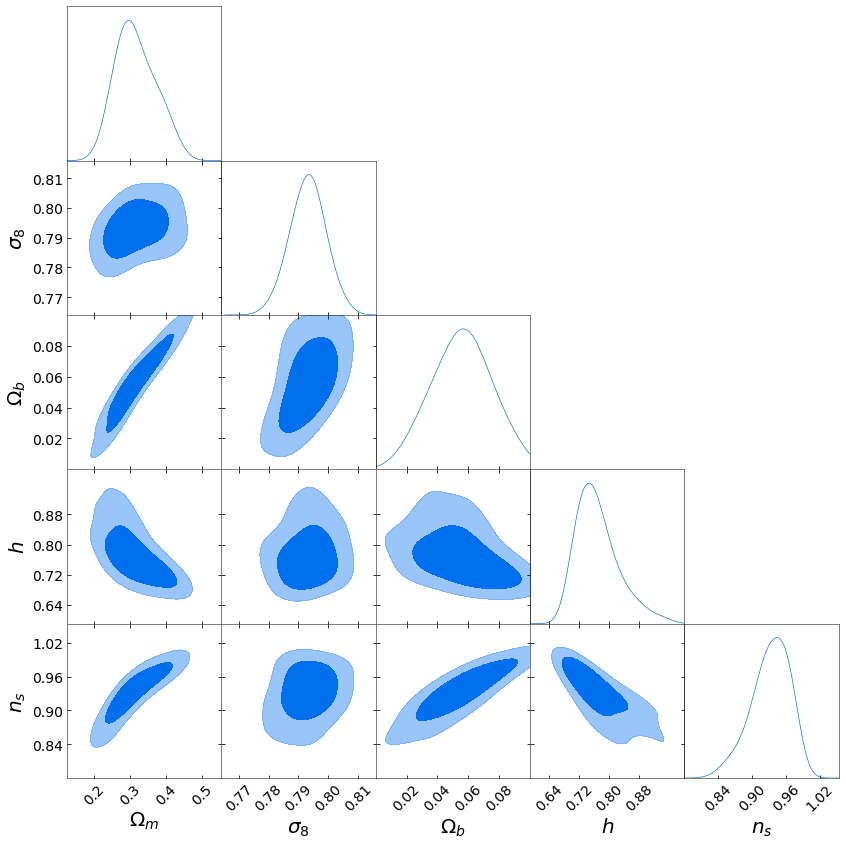

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


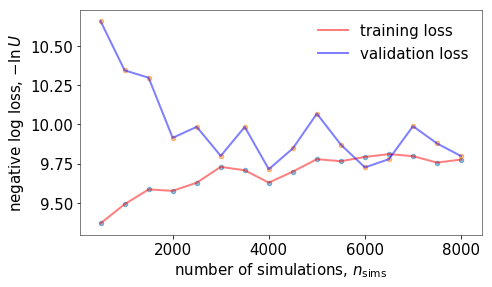

Population 16/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8159, Val_loss: 9.7437
Epoch 00001, Train_loss: 9.8068, Val_loss: 9.7276
Epoch 00002, Train_loss: 9.8078, Val_loss: 9.7360
Epoch 00003, Train_loss: 9.7978, Val_loss: 9.7325
Epoch 00004, Train_loss: 9.8034, Val_loss: 9.7459
Epoch 00005, Train_loss: 9.7933, Val_loss: 9.7382
Epoch 00006, Train_loss: 9.7924, Val_loss: 9.7407
Epoch 00007, Train_loss: 9.7879, Val_loss: 9.7487
Epoch 00008, Train_loss: 9.7921, Val_loss: 9.7547
Epoch 00009, Train_loss: 9.7910, Val_loss: 9.7580
Epoch 00010, Train_loss: 9.7888, Val_loss: 9.7612
Epoch 00011, Train_loss: 9.7889, Val_loss: 9.7760
Epoch 00012, Train_loss: 9.7765, Val_loss: 9.7481
Epoch 00013, Train_loss: 9.7735, Val_loss: 9.7555
Epoch 00014, Train_loss: 9.8136, Val_loss: 9.8161
Epoch 00015, Train_loss: 9.7684, Val_loss: 9.7471
Epoch 00016, Train_loss: 9.7738, Val_loss: 9.7492
Epoch 00017, Train_loss: 9.7703, Val_loss: 9.7547
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_16.pdf


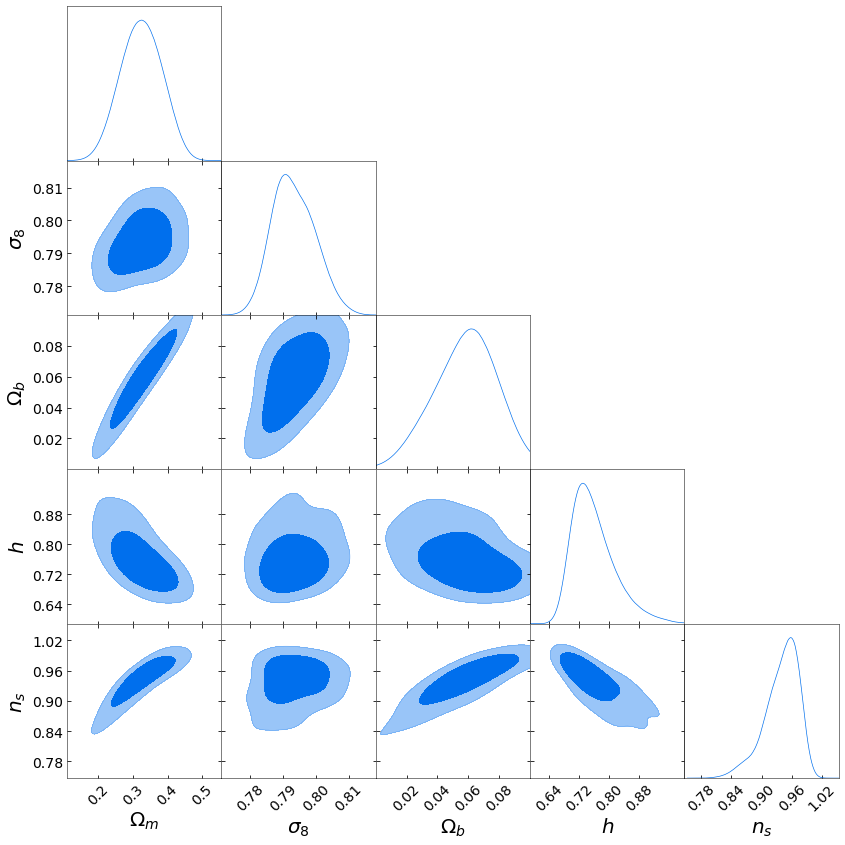

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


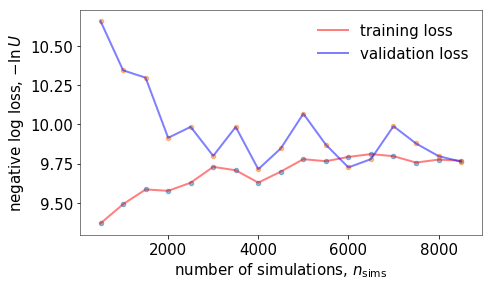

Population 17/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8322, Val_loss: 9.7923
Epoch 00001, Train_loss: 9.8017, Val_loss: 9.7838
Epoch 00002, Train_loss: 9.8109, Val_loss: 9.7882
Epoch 00003, Train_loss: 9.7920, Val_loss: 9.7819
Epoch 00004, Train_loss: 9.7930, Val_loss: 9.7900
Epoch 00005, Train_loss: 9.8046, Val_loss: 9.8010
Epoch 00006, Train_loss: 9.7869, Val_loss: 9.7860
Epoch 00007, Train_loss: 9.7933, Val_loss: 9.7905
Epoch 00008, Train_loss: 9.7851, Val_loss: 9.7922
Epoch 00009, Train_loss: 9.7843, Val_loss: 9.7946
Epoch 00010, Train_loss: 9.7814, Val_loss: 9.7951
Epoch 00011, Train_loss: 9.7843, Val_loss: 9.8019
Epoch 00012, Train_loss: 9.7719, Val_loss: 9.7920
Epoch 00013, Train_loss: 9.7786, Val_loss: 9.7917
Epoch 00014, Train_loss: 9.7717, Val_loss: 9.7919
Epoch 00015, Train_loss: 9.7761, Val_loss: 9.8095
Epoch 00016, Train_loss: 9.7756, Val_loss: 9.8055
Epoch 00017, Train_loss: 9.7668, Val_loss: 9.8014
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_17.pdf


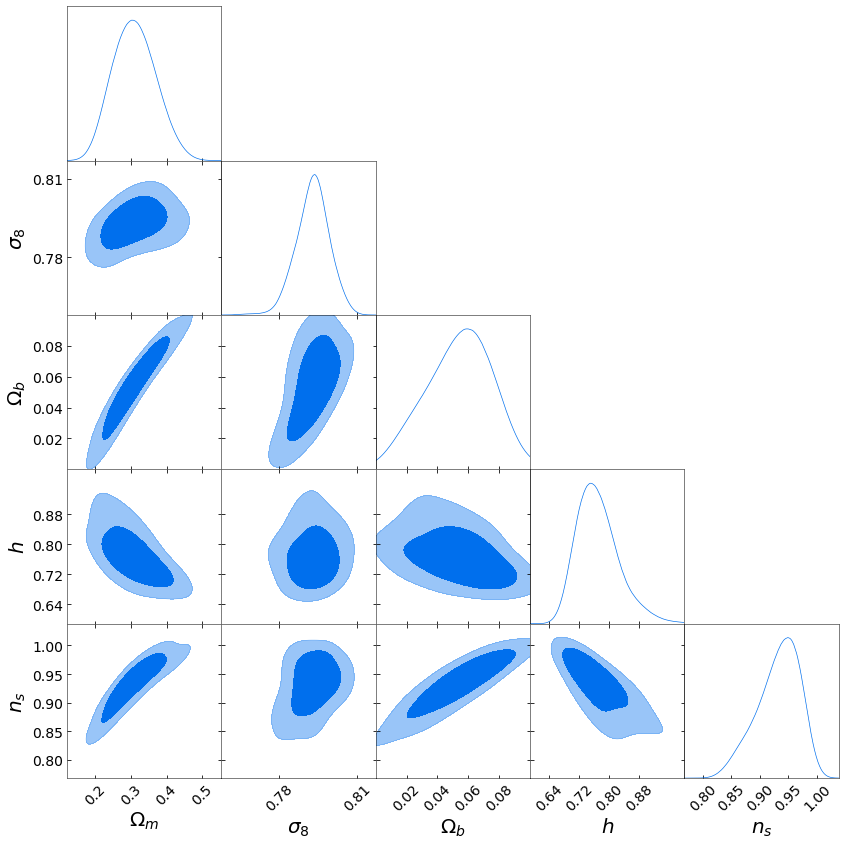

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


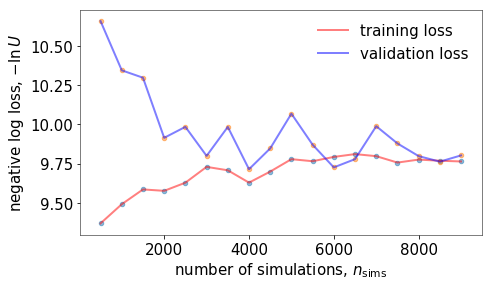

Population 18/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.7935, Val_loss: 9.8061
Epoch 00001, Train_loss: 9.8094, Val_loss: 9.8222
Epoch 00002, Train_loss: 9.7825, Val_loss: 9.8059
Epoch 00003, Train_loss: 9.7867, Val_loss: 9.8133
Epoch 00004, Train_loss: 9.7832, Val_loss: 9.8128
Epoch 00005, Train_loss: 9.7822, Val_loss: 9.8095
Epoch 00006, Train_loss: 9.7892, Val_loss: 9.8320
Epoch 00007, Train_loss: 9.7700, Val_loss: 9.8057
Epoch 00008, Train_loss: 9.7738, Val_loss: 9.8077
Epoch 00009, Train_loss: 9.7755, Val_loss: 9.8165
Epoch 00010, Train_loss: 9.7747, Val_loss: 9.8239
Epoch 00011, Train_loss: 9.7652, Val_loss: 9.8116
Epoch 00012, Train_loss: 9.7829, Val_loss: 9.8348
Epoch 00013, Train_loss: 9.7675, Val_loss: 9.8238
Epoch 00014, Train_loss: 9.7667, Val_loss: 9.8266
Epoch 00015, Train_loss: 9.7598, Val_loss: 9.8125
Epoch 00016, Train_loss: 9.7742, Val_loss: 9.8313
Epoch 00017, Train_loss: 9.7593, Val_loss: 9.8215
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_18.pdf


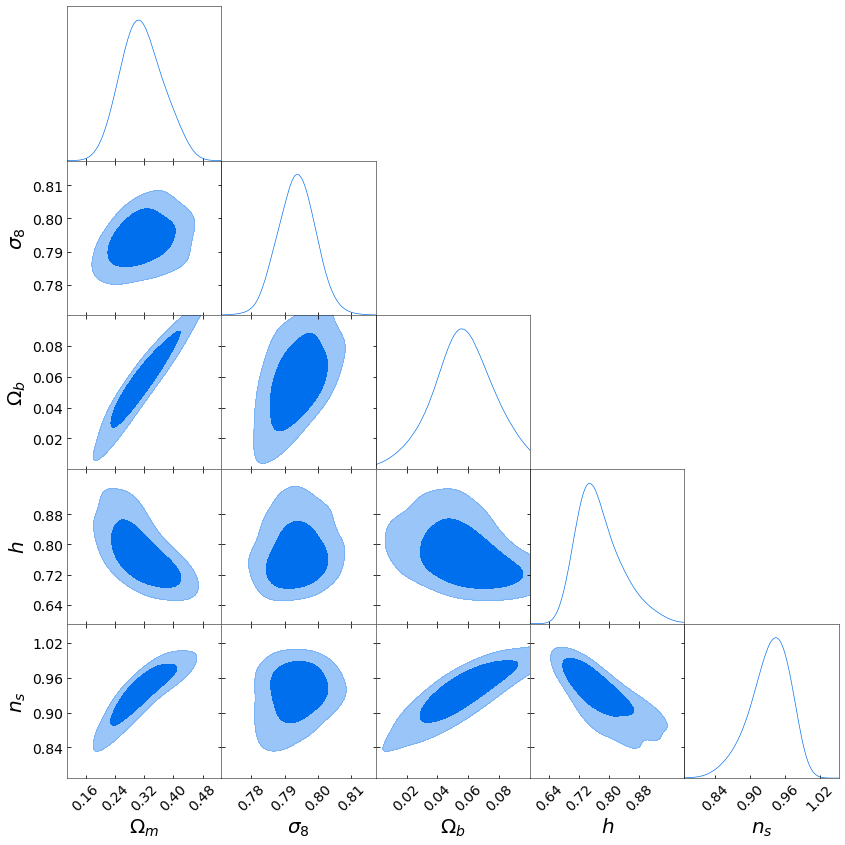

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


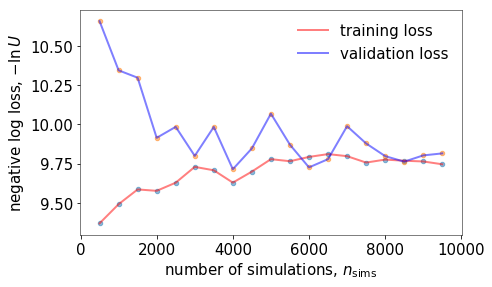

Population 19/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.7813, Val_loss: 9.8006
Epoch 00001, Train_loss: 9.7791, Val_loss: 9.8057
Epoch 00002, Train_loss: 9.7726, Val_loss: 9.8080
Epoch 00003, Train_loss: 9.7820, Val_loss: 9.8226
Epoch 00004, Train_loss: 9.8023, Val_loss: 9.8437
Epoch 00005, Train_loss: 9.7779, Val_loss: 9.8342
Epoch 00006, Train_loss: 9.8013, Val_loss: 9.8606
Epoch 00007, Train_loss: 9.7698, Val_loss: 9.8265
Epoch 00008, Train_loss: 9.7739, Val_loss: 9.8393
Epoch 00009, Train_loss: 9.7610, Val_loss: 9.8353
Epoch 00010, Train_loss: 9.7682, Val_loss: 9.8476
Epoch 00011, Train_loss: 9.7717, Val_loss: 9.8569
Epoch 00012, Train_loss: 9.7568, Val_loss: 9.8386
Epoch 00013, Train_loss: 9.7651, Val_loss: 9.8553
Epoch 00014, Train_loss: 9.7618, Val_loss: 9.8486
Epoch 00015, Train_loss: 9.7514, Val_loss: 9.8444
Epoch 00016, Train_loss: 9.7523, Val_loss: 9.8466
Epoch 00017, Train_loss: 9.7556, Val_loss: 9.8567
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_19.pdf


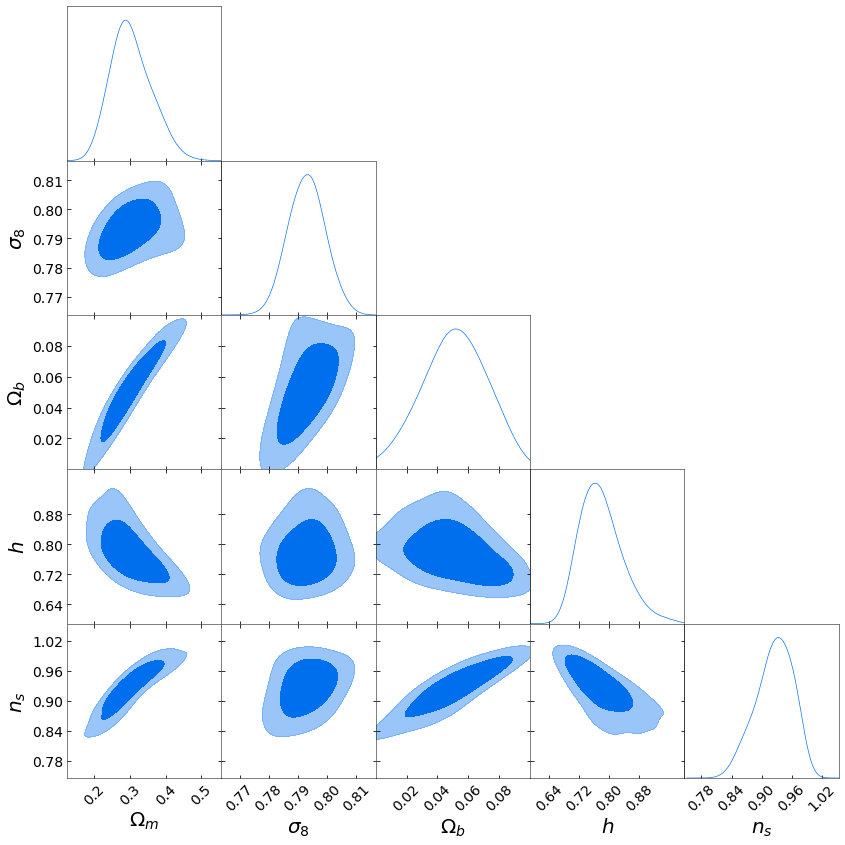

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


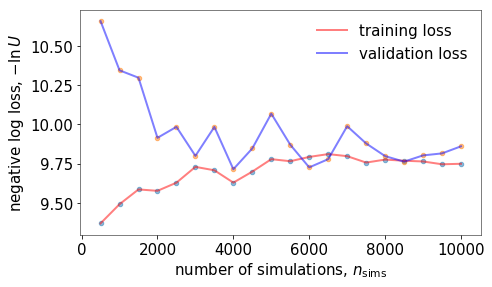

Population 20/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.7920, Val_loss: 9.8666
Epoch 00001, Train_loss: 9.7841, Val_loss: 9.8544
Epoch 00002, Train_loss: 9.7769, Val_loss: 9.8606
Epoch 00003, Train_loss: 9.7817, Val_loss: 9.8671
Epoch 00004, Train_loss: 9.7730, Val_loss: 9.8603
Epoch 00005, Train_loss: 9.7680, Val_loss: 9.8639
Epoch 00006, Train_loss: 9.7695, Val_loss: 9.8628
Epoch 00007, Train_loss: 9.7716, Val_loss: 9.8742
Epoch 00008, Train_loss: 9.7729, Val_loss: 9.8721
Epoch 00009, Train_loss: 9.7658, Val_loss: 9.8695
Epoch 00010, Train_loss: 9.7673, Val_loss: 9.8883
Epoch 00011, Train_loss: 9.7629, Val_loss: 9.8707
Epoch 00012, Train_loss: 9.7630, Val_loss: 9.8849
Epoch 00013, Train_loss: 9.7706, Val_loss: 9.8986
Epoch 00014, Train_loss: 9.7604, Val_loss: 9.8808
Epoch 00015, Train_loss: 9.7558, Val_loss: 9.8756
Epoch 00016, Train_loss: 9.7577, Val_loss: 9.8709
Epoch 00017, Train_loss: 9.7595, Val_loss: 9.8970
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_20.pdf


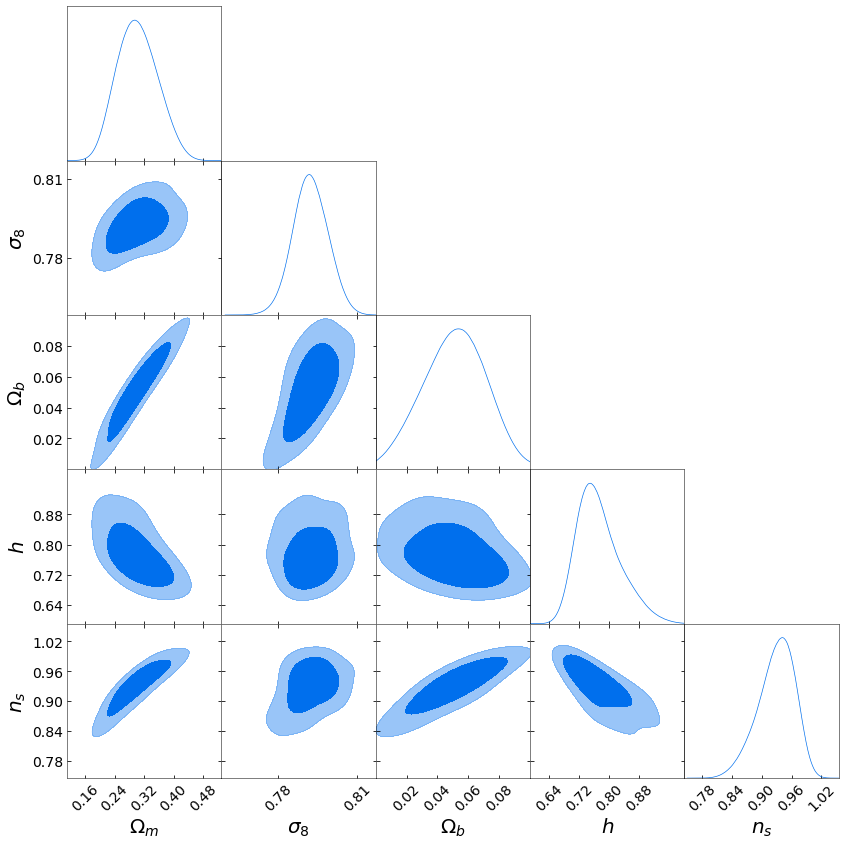

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


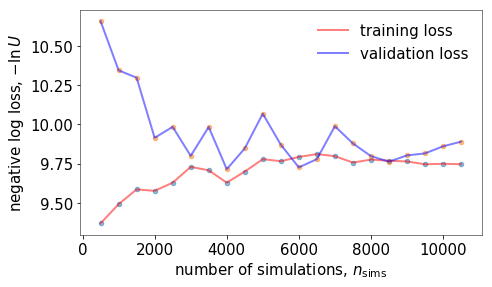

Population 21/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.7889, Val_loss: 9.8173
Epoch 00001, Train_loss: 9.8150, Val_loss: 9.8579
Epoch 00002, Train_loss: 9.7848, Val_loss: 9.8277
Epoch 00003, Train_loss: 9.7847, Val_loss: 9.8248
Epoch 00004, Train_loss: 9.7862, Val_loss: 9.8329
Epoch 00005, Train_loss: 9.7835, Val_loss: 9.8379
Epoch 00006, Train_loss: 9.7784, Val_loss: 9.8250
Epoch 00007, Train_loss: 9.7739, Val_loss: 9.8304
Epoch 00008, Train_loss: 9.7815, Val_loss: 9.8322
Epoch 00009, Train_loss: 9.7840, Val_loss: 9.8326
Epoch 00010, Train_loss: 9.7837, Val_loss: 9.8346
Epoch 00011, Train_loss: 9.7763, Val_loss: 9.8369
Epoch 00012, Train_loss: 9.7686, Val_loss: 9.8341
Epoch 00013, Train_loss: 9.7744, Val_loss: 9.8474
Epoch 00014, Train_loss: 9.7634, Val_loss: 9.8349
Epoch 00015, Train_loss: 9.7720, Val_loss: 9.8434
Epoch 00016, Train_loss: 9.7886, Val_loss: 9.8716
Epoch 00017, Train_loss: 9.7641, Val_loss: 9.8375
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_21.pdf


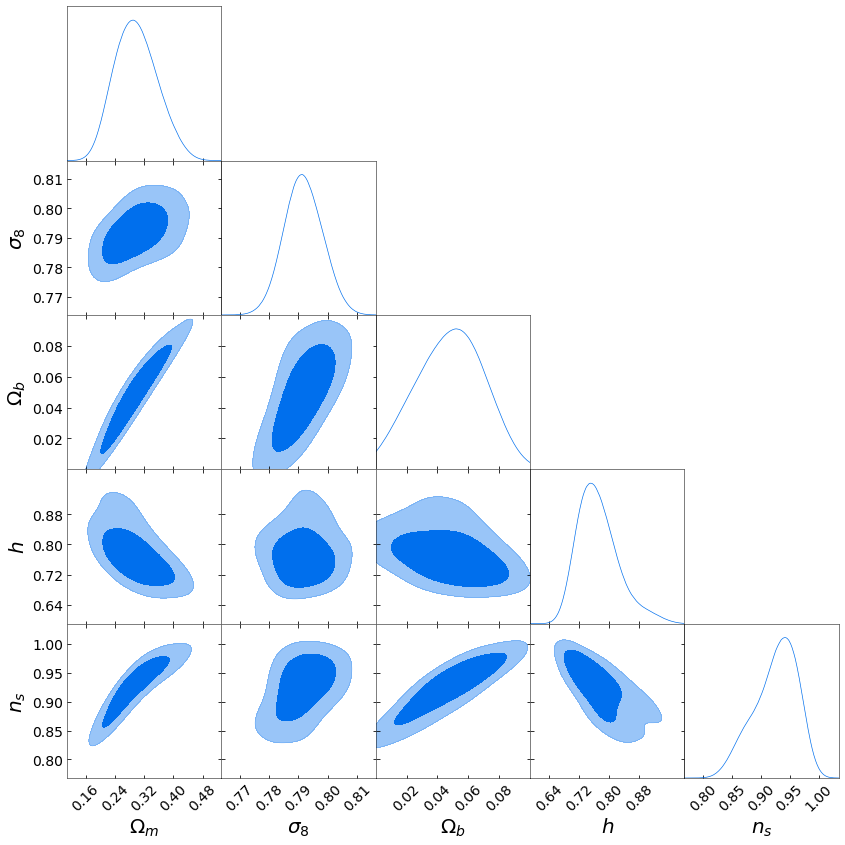

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


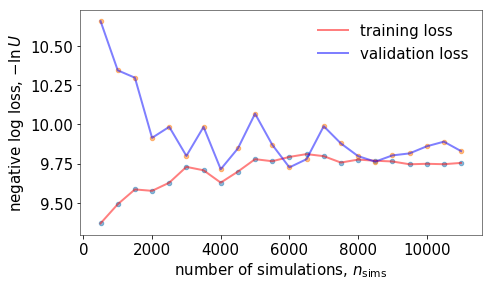

Population 22/23
Sampling proposal density...
Done.
Running 500 sims...
Done.
Epoch 00000, Train_loss: 9.8003, Val_loss: 9.7903
Epoch 00001, Train_loss: 9.7995, Val_loss: 9.7867
Epoch 00002, Train_loss: 9.7898, Val_loss: 9.7831
Epoch 00003, Train_loss: 9.7881, Val_loss: 9.7831
Epoch 00004, Train_loss: 9.7892, Val_loss: 9.7882
Epoch 00005, Train_loss: 9.7867, Val_loss: 9.7884
Epoch 00006, Train_loss: 9.7823, Val_loss: 9.7895
Epoch 00007, Train_loss: 9.7799, Val_loss: 9.7834
Epoch 00008, Train_loss: 9.7818, Val_loss: 9.7857
Epoch 00009, Train_loss: 9.7781, Val_loss: 9.7832
Epoch 00010, Train_loss: 9.7748, Val_loss: 9.7914
Epoch 00011, Train_loss: 9.7734, Val_loss: 9.7856
Epoch 00012, Train_loss: 9.7732, Val_loss: 9.7943
Epoch 00013, Train_loss: 9.7751, Val_loss: 9.8009
Epoch 00014, Train_loss: 9.7682, Val_loss: 9.7857
Epoch 00015, Train_loss: 9.7707, Val_loss: 9.7837
Epoch 00016, Train_loss: 9.7698, Val_loss: 9.7996
Epoch 00017, Train_loss: 9.7889, Val_loss: 9.8013
Epoch 00018, Train_los

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_22.pdf


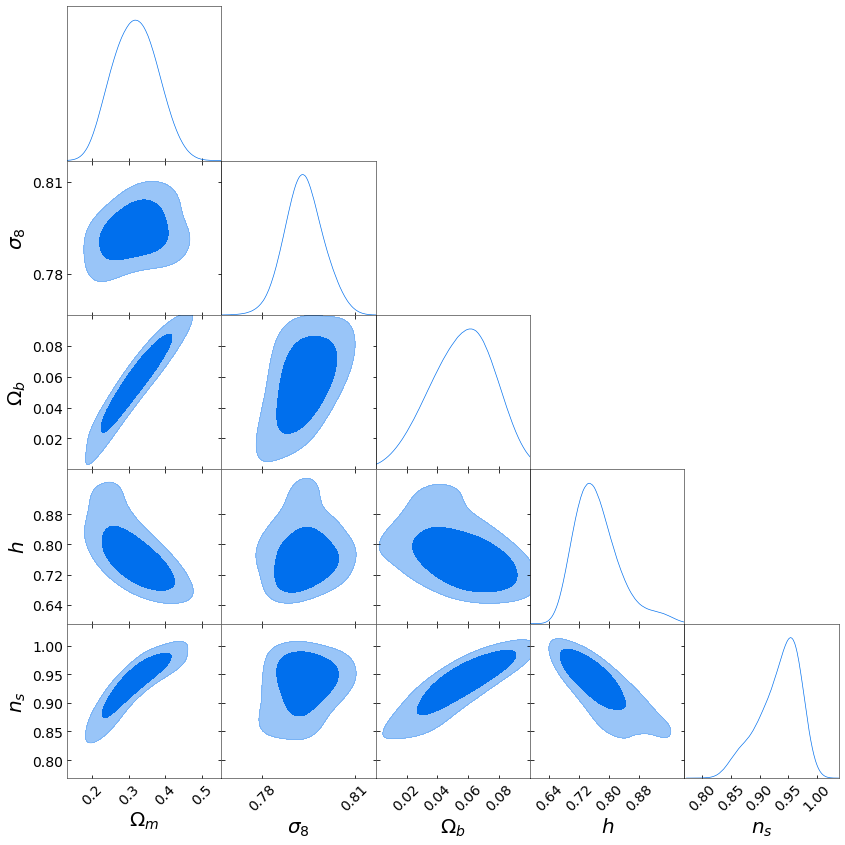

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


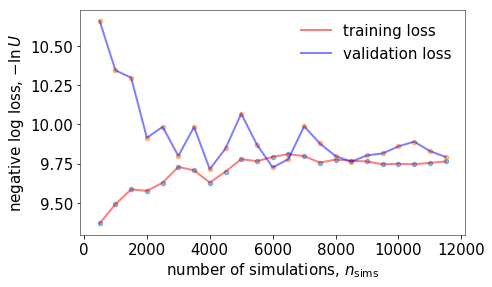

Population 23/23
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.14655802 0.77791999 0.00188288 0.86238233 0.85306072] (rank 0)
Simulator returns exception for parameter values: [0.1440947  0.79643327 0.0138819  0.9853079  0.83389675] (rank 0)
Simulator returns exception for parameter values: [0.1440947  0.79643327 0.0138819  0.9853079  0.83389675] (rank 0)
Simulator returns exception for parameter values: [0.14218494 0.79647202 0.0132259  0.9874666  0.83246581] (rank 0)
Simulator returns exception for parameter values: [0.14218494 0.79647202 0.0132259  0.9874666  0.83246581] (rank 0)
Simulator returns exception for parameter values: [0.15461854 0.79703511 0.01654101 0.97569761 0.8385314 ] (rank 0)
Simulator returns exception for parameter values: [0.15461854 0.79703511 0.01654101 0.97569761 0.8385314 ] (rank 0)
Simulator returns exception for parameter values: [0.16517654 0.78939418 0.01211404 0.84117629 0.86265669] (rank 0)


INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/maftmp_model


Sampling approximate posterior...
Done.
Saving simulators/cosmic_shear/results_marginal/mafseq_train_post_23.pdf


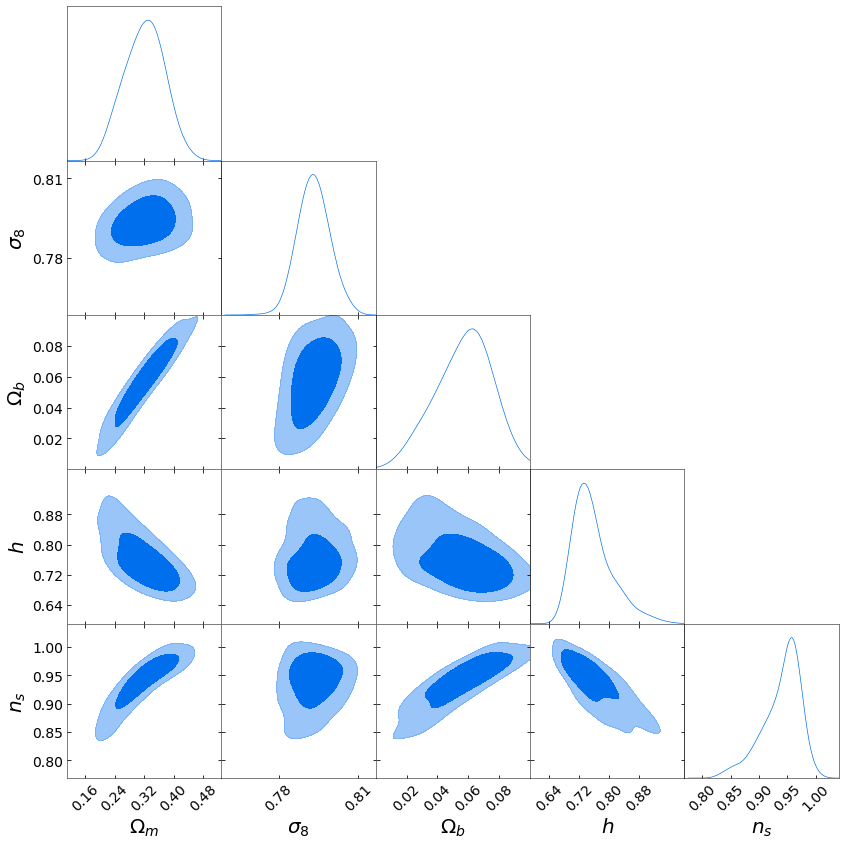

Saving simulators/cosmic_shear/results_marginal/mafseq_train_loss.pdf


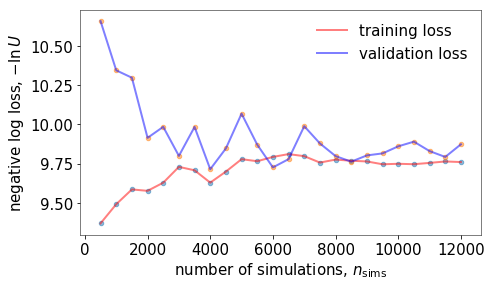

In [8]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
Delfi.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args)

In [9]:
MDN = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
DelfiMDN = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', '\sigma_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results_marginal/mdn")

Generating fisher pre-training data...
Training the neural density estimator...
Epoch 00000, Train_loss: 81.8160, Val_loss: 81.6100
Epoch 00001, Train_loss: 65.6233, Val_loss: 65.5427
Epoch 00002, Train_loss: 31.5343, Val_loss: 31.4627
Epoch 00003, Train_loss: 22.7309, Val_loss: 22.6633
Epoch 00004, Train_loss: 19.4166, Val_loss: 19.4119
Epoch 00005, Train_loss: 18.5700, Val_loss: 18.6172
Epoch 00006, Train_loss: 17.7898, Val_loss: 17.8062
Epoch 00007, Train_loss: 17.6673, Val_loss: 17.7401
Epoch 00008, Train_loss: 17.0023, Val_loss: 17.0592
Epoch 00009, Train_loss: 16.9138, Val_loss: 16.9921
Epoch 00010, Train_loss: 16.8357, Val_loss: 17.0043
Epoch 00011, Train_loss: 16.6623, Val_loss: 16.7916
Epoch 00012, Train_loss: 16.0581, Val_loss: 16.0968
Epoch 00013, Train_loss: 15.8583, Val_loss: 15.8611
Epoch 00014, Train_loss: 15.4749, Val_loss: 15.5130
Epoch 00015, Train_loss: 15.6821, Val_loss: 15.7901
Epoch 00016, Train_loss: 15.3944, Val_loss: 15.4562
Epoch 00017, Train_loss: 14.9919, Va

Epoch 00161, Train_loss: 6.4207, Val_loss: 6.4584
Epoch 00162, Train_loss: 6.8972, Val_loss: 6.9385
Epoch 00163, Train_loss: 6.3968, Val_loss: 6.4361
Epoch 00164, Train_loss: 6.4273, Val_loss: 6.4529
Epoch 00165, Train_loss: 6.4511, Val_loss: 6.4654
Epoch 00166, Train_loss: 6.5219, Val_loss: 6.5550
Epoch 00167, Train_loss: 6.7692, Val_loss: 6.7990
Epoch 00168, Train_loss: 6.5635, Val_loss: 6.6237
Epoch 00169, Train_loss: 6.7053, Val_loss: 6.7377
Epoch 00170, Train_loss: 6.4221, Val_loss: 6.4502
Epoch 00171, Train_loss: 6.5620, Val_loss: 6.5938
Epoch 00172, Train_loss: 6.6325, Val_loss: 6.6629
Epoch 00173, Train_loss: 6.6986, Val_loss: 6.7370
Epoch 00174, Train_loss: 6.6011, Val_loss: 6.6177
Epoch 00175, Train_loss: 6.3268, Val_loss: 6.3557
Epoch 00176, Train_loss: 6.3487, Val_loss: 6.3875
Epoch 00177, Train_loss: 6.4224, Val_loss: 6.4762
Epoch 00178, Train_loss: 6.5153, Val_loss: 6.5523
Epoch 00179, Train_loss: 6.4117, Val_loss: 6.4377
Epoch 00180, Train_loss: 6.3264, Val_loss: 6.3626


Epoch 00326, Train_loss: 00nan, Val_loss: 00nan
Epoch 00327, Train_loss: 00nan, Val_loss: 00nan
Epoch 00328, Train_loss: 00nan, Val_loss: 00nan
Epoch 00329, Train_loss: 00nan, Val_loss: 00nan
Epoch 00330, Train_loss: 00nan, Val_loss: 00nan
Epoch 00331, Train_loss: 00nan, Val_loss: 00nan
Epoch 00332, Train_loss: 00nan, Val_loss: 00nan
Epoch 00333, Train_loss: 00nan, Val_loss: 00nan
Epoch 00334, Train_loss: 00nan, Val_loss: 00nan
Epoch 00335, Train_loss: 00nan, Val_loss: 00nan
Epoch 00336, Train_loss: 00nan, Val_loss: 00nan
Epoch 00337, Train_loss: 00nan, Val_loss: 00nan
Epoch 00338, Train_loss: 00nan, Val_loss: 00nan
Epoch 00339, Train_loss: 00nan, Val_loss: 00nan
Epoch 00340, Train_loss: 00nan, Val_loss: 00nan
Epoch 00341, Train_loss: 00nan, Val_loss: 00nan
Epoch 00342, Train_loss: 00nan, Val_loss: 00nan
Epoch 00343, Train_loss: 00nan, Val_loss: 00nan
Epoch 00344, Train_loss: 00nan, Val_loss: 00nan
Epoch 00345, Train_loss: 00nan, Val_loss: 00nan
Epoch 00346, Train_loss: 00nan, Val_loss

INFO:tensorflow:Restoring parameters from ./simulators/cosmic_shear/results_marginal/mdntmp_model


Done.
Sampling approximate posterior...
Done.
Plotting the posterior (1D and 2D marginals)...
Saving simulators/cosmic_shear/results_marginal/mdnfisher_pretrain_post.pdf


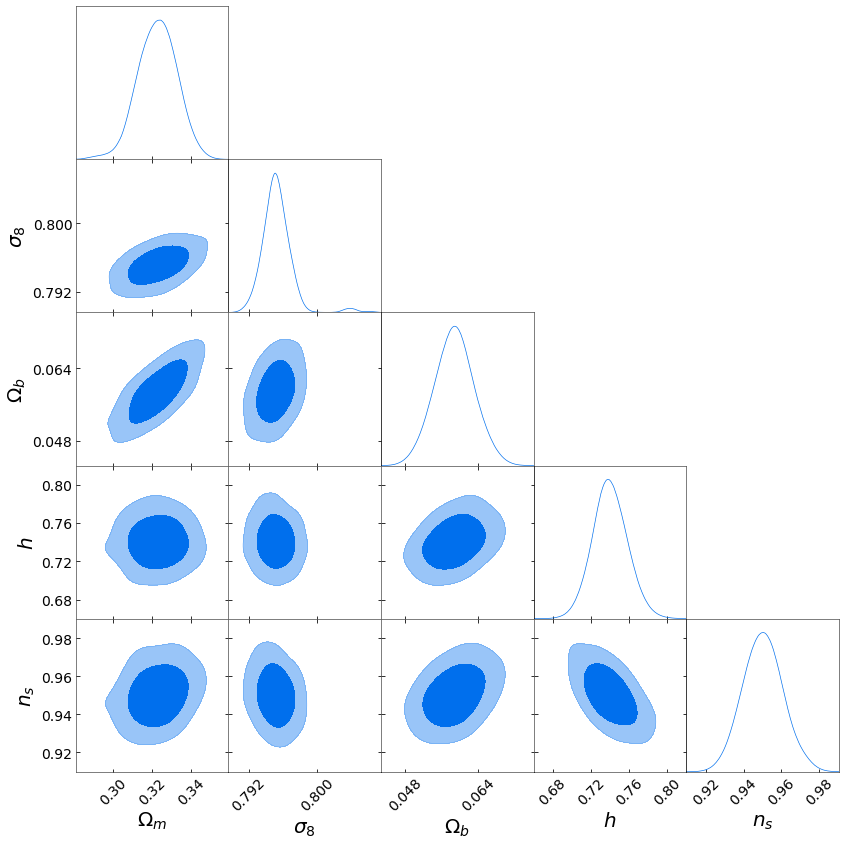

In [10]:
# Do the Fisher pre-training
DelfiMDN.fisher_pretraining(50000, prior, epochs=500, patience=100)

In [11]:
# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 23

# Do the SNL training
Delfi.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args)

Running initial 500 sims...
Done.
Epoch 00000, Train_loss: 9.8119, Val_loss: 9.8539


FailedPreconditionError: Attempting to use uninitialized value beta1_power_1
	 [[{{node save_26/SaveV2}} = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_26/Const_0_0, save_26/SaveV2/tensor_names, save_26/SaveV2/shape_and_slices, W1, W1/Adam, W1/Adam_1, W1_1, W1_1/Adam, W1_1/Adam_1, W1_2, W1_2/Adam, W1_2/Adam_1, W1_3, W1_3/Adam, W1_3/Adam_1, W1_4, W1_4/Adam, W1_4/Adam_1, W2, W2/Adam, W2/Adam_1, W2_1, W2_1/Adam, W2_1/Adam_1, W2_2, W2_2/Adam, W2_2/Adam_1, W2_3, W2_3/Adam, W2_3/Adam_1, W2_4, W2_4/Adam, W2_4/Adam_1, Wm, Wm/Adam, Wm/Adam_1, Wm_1, Wm_1/Adam, Wm_1/Adam_1, Wm_2, Wm_2/Adam, Wm_2/Adam_1, Wm_3, Wm_3/Adam, Wm_3/Adam_1, Wm_4, Wm_4/Adam, Wm_4/Adam_1, Wp, Wp/Adam, Wp/Adam_1, Wp_1, Wp_1/Adam, Wp_1/Adam_1, Wp_2, Wp_2/Adam, Wp_2/Adam_1, Wp_3, Wp_3/Adam, Wp_3/Adam_1, Wp_4, Wp_4/Adam, Wp_4/Adam_1, Wx, Wx/Adam, Wx/Adam_1, Wx_1, Wx_1/Adam, Wx_1/Adam_1, Wx_2, Wx_2/Adam, Wx_2/Adam_1, Wx_3, Wx_3/Adam, Wx_3/Adam_1, Wx_4, Wx_4/Adam, Wx_4/Adam_1, b1, b1/Adam, b1/Adam_1, b1_1, b1_1/Adam, b1_1/Adam_1, b1_2, b1_2/Adam, b1_2/Adam_1, b1_3, b1_3/Adam, b1_3/Adam_1, b1_4, b1_4/Adam, b1_4/Adam_1, b2, b2/Adam, b2/Adam_1, b2_1, b2_1/Adam, b2_1/Adam_1, b2_2, b2_2/Adam, b2_2/Adam_1, b2_3, b2_3/Adam, b2_3/Adam_1, b2_4, b2_4/Adam, b2_4/Adam_1, beta1_power, beta1_power_1, beta2_power, beta2_power_1, bm, bm/Adam, bm/Adam_1, bm_1, bm_1/Adam, bm_1/Adam_1, bm_2, bm_2/Adam, bm_2/Adam_1, bm_3, bm_3/Adam, bm_3/Adam_1, bm_4, bm_4/Adam, bm_4/Adam_1, bp, bp/Adam, bp/Adam_1, bp_1, bp_1/Adam, bp_1/Adam_1, bp_2, bp_2/Adam, bp_2/Adam_1, bp_3, bp_3/Adam, bp_3/Adam_1, bp_4, bp_4/Adam, bp_4/Adam_1, layer_1/biases, layer_1/biases/Adam, layer_1/biases/Adam_1, layer_1/weights, layer_1/weights/Adam, layer_1/weights/Adam_1, layer_2/biases, layer_2/biases/Adam, layer_2/biases/Adam_1, layer_2/weights, layer_2/weights/Adam, layer_2/weights/Adam_1)]]

Caused by op 'save_26/SaveV2', defined at:
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-16d2ba0de9a7>", line 7, in <module>
    Delfi.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, simulator_args=simulator_args)
  File "/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_JUSTIN/delfi/delfi.py", line 243, in sequential_training
    patience=patience, saver_name='{}tmp_model'.format(self.results_dir))
  File "/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI_JUSTIN/ndes/train.py", line 162, in train
    saver = tf.train.Saver()
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1094, in __init__
    self.build()
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1106, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1143, in _build
    build_save=build_save, build_restore=build_restore)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 784, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 284, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 202, in save_op
    tensors)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1690, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta1_power_1
	 [[{{node save_26/SaveV2}} = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_26/Const_0_0, save_26/SaveV2/tensor_names, save_26/SaveV2/shape_and_slices, W1, W1/Adam, W1/Adam_1, W1_1, W1_1/Adam, W1_1/Adam_1, W1_2, W1_2/Adam, W1_2/Adam_1, W1_3, W1_3/Adam, W1_3/Adam_1, W1_4, W1_4/Adam, W1_4/Adam_1, W2, W2/Adam, W2/Adam_1, W2_1, W2_1/Adam, W2_1/Adam_1, W2_2, W2_2/Adam, W2_2/Adam_1, W2_3, W2_3/Adam, W2_3/Adam_1, W2_4, W2_4/Adam, W2_4/Adam_1, Wm, Wm/Adam, Wm/Adam_1, Wm_1, Wm_1/Adam, Wm_1/Adam_1, Wm_2, Wm_2/Adam, Wm_2/Adam_1, Wm_3, Wm_3/Adam, Wm_3/Adam_1, Wm_4, Wm_4/Adam, Wm_4/Adam_1, Wp, Wp/Adam, Wp/Adam_1, Wp_1, Wp_1/Adam, Wp_1/Adam_1, Wp_2, Wp_2/Adam, Wp_2/Adam_1, Wp_3, Wp_3/Adam, Wp_3/Adam_1, Wp_4, Wp_4/Adam, Wp_4/Adam_1, Wx, Wx/Adam, Wx/Adam_1, Wx_1, Wx_1/Adam, Wx_1/Adam_1, Wx_2, Wx_2/Adam, Wx_2/Adam_1, Wx_3, Wx_3/Adam, Wx_3/Adam_1, Wx_4, Wx_4/Adam, Wx_4/Adam_1, b1, b1/Adam, b1/Adam_1, b1_1, b1_1/Adam, b1_1/Adam_1, b1_2, b1_2/Adam, b1_2/Adam_1, b1_3, b1_3/Adam, b1_3/Adam_1, b1_4, b1_4/Adam, b1_4/Adam_1, b2, b2/Adam, b2/Adam_1, b2_1, b2_1/Adam, b2_1/Adam_1, b2_2, b2_2/Adam, b2_2/Adam_1, b2_3, b2_3/Adam, b2_3/Adam_1, b2_4, b2_4/Adam, b2_4/Adam_1, beta1_power, beta1_power_1, beta2_power, beta2_power_1, bm, bm/Adam, bm/Adam_1, bm_1, bm_1/Adam, bm_1/Adam_1, bm_2, bm_2/Adam, bm_2/Adam_1, bm_3, bm_3/Adam, bm_3/Adam_1, bm_4, bm_4/Adam, bm_4/Adam_1, bp, bp/Adam, bp/Adam_1, bp_1, bp_1/Adam, bp_1/Adam_1, bp_2, bp_2/Adam, bp_2/Adam_1, bp_3, bp_3/Adam, bp_3/Adam_1, bp_4, bp_4/Adam, bp_4/Adam_1, layer_1/biases, layer_1/biases/Adam, layer_1/biases/Adam_1, layer_1/weights, layer_1/weights/Adam, layer_1/weights/Adam_1, layer_2/biases, layer_2/biases/Adam, layer_2/biases/Adam_1, layer_2/weights, layer_2/weights/Adam, layer_2/weights/Adam_1)]]


In [18]:
# Generate draws from asymptotic posterior
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

samples_asymptotic = np.array([asymptotic_posterior.draw() for i in range(100000)])

In [19]:
samples = [mdn.posterior_samples, samples_asymptotic]
mc_samples = [MCSamples(samples=s, names = mdn.names, labels = mdn.labels, ranges = mdn.ranges) for s in samples]

In [14]:
# Triangle plot

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black',
                 'axes.color_cycle': ['#E41A1C', '#377EB8', '#4DAF4A', '#FF7F00']})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
#g.triangle_plot(mc_samples[0], filled_compare=True, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
#g.triangle_plot(mc_samples[1], filled_compare=False, normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_ls = ['-.','-.'], contour_colors=['red','red'])
g.triangle_plot(mc_samples, filled_compare=[True,False], normalized=True, legend_labels=['Density estimation likelihood-free inference'], contour_lws = [1, 1], contour_ls = ['-','-.'], contour_colors=['#E41A1C','#377EB8'])

for i in range(0, len(samples[0][0,:])):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.sho
#plt.savefig('../paper_II/plots/contours.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


NameError: name 'mc_samples' is not defined